# FINAL PROJECT 3: UNDERSTANDING THE CONCEPT OF CLASSIFICATION WITH ENSAMBLE MODELS.
This project is prepared to fulfill the third final assignment of the course Introduction to Python for Data Science.

### Group Members:
1. Tamara Cyntia Elizabeth Sihombing
2. Taj Mahdy Muhadzdzib

# Introduction

Heart failure is a critical condition that affects millions of individuals worldwide, causing significant morbidity and mortality rates. Early prediction and accurate diagnosis of heart failure play a crucial role in providing timely interventions and improving patient outcomes. With advancements in machine learning techniques, the development of predictive models has gained significant attention in the medical field.

In recent years, Kaggle, a popular online community for data science and machine learning enthusiasts, has provided researchers and data scientists with a vast array of datasets to explore and develop innovative solutions. One such dataset available on Kaggle is the [Heart Failure Prediction dataset ](https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data). This dataset contains various clinical features and patient attributes, allowing for the prediction of heart failure occurrence.

To effectively predict heart failure using the Heart Failure Prediction dataset, a single classifier may not provide the desired accuracy and robustness. This is where ensemble learning comes into play. Ensemble learning combines multiple individual classifiers to create a stronger, more reliable predictive model. By leveraging the diversity of these individual classifiers and their collective decision-making, ensemble models can often outperform single models and provide more accurate predictions.

In this project, we aim to develop a classification model using an ensemble learning approach on the Heart Failure Prediction dataset from Kaggle. We will explore various ensemble methods such as bagging, boosting, and stacking to construct a robust and accurate predictive model. By combining the predictions of multiple classifiers, we can potentially enhance the model's generalization ability and improve its performance in identifying individuals at risk of heart failure.

The remainder of this project will be structured as follows: first, we will provide an overview of the Heart Failure Prediction dataset and its key features. Next, we will discuss the ensemble learning techniques employed and the rationale behind their selection. We will then present the methodology used for preprocessing the dataset and feature engineering. Subsequently, we will describe the implementation of the ensemble model and evaluate its performance using appropriate evaluation metrics. Finally, we will conclude with a discussion of the results, limitations, and potential avenues for future research.

The ultimate goal of this project is to contribute to the development of an accurate and reliable heart failure prediction model that can assist healthcare professionals in making informed decisions and providing appropriate care to individuals at risk. By leveraging the power of ensemble learning, we aim to improve the accuracy and reliability of heart failure predictions, thus positively impacting patient outcomes and reducing the burden on healthcare systems.

## Libraries

In [62]:
# Data Wrangling
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.integrate import simps

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from pickle import dump,load

# Oversampling and Undersampling
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler,NearMiss
from imblearn.combine import SMOTETomek,SMOTEENN

# Settings
pd.set_option("display.max.columns",None)
%matplotlib inline
mpl.style.use(["ggplot"])

## Data Load

Import the dataset named "heart_failure_clinical_records_dataset.csv" as `df` and convert the names of all columns to lowercase.

In [63]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.columns = df.columns.str.lower()
df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  death_event  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

You can determine the dimensions of the dataset by using the `shape` attribute of the DataFrame. 

In [64]:
print(f"Number of Rows\t\t: {df.shape[0]}")
print(f"Number of Columns\t: {df.shape[1]}")

Number of Rows		: 299
Number of Columns	: 13


Running `print(df.shape)` will display the dimensions as `(299, 13)`, indicating that the dataset consists of 299 rows and 13 columns.

## Data Cleaning

To enhance clarity, let's modify the "death_event" column by renaming 0 as "Survived" and 1 as "Dead".

In [65]:
df["death_event"] = df["death_event"].replace({0:"Survived",1:"Dead"})

To gain a more comprehensive understanding of the dataset, examine the type of each variable, identify any null values, determine the number of unique values, and review a sample of the data.

In [66]:
pd.DataFrame({
    "type":df.dtypes.values,
    "null":df.isnull().sum().values,
    "null_percentage":df.isnull().sum().values / len(df) * 100,
    "unique":[df[i].nunique() for i in df.columns],
    "sample":[list(pd.Series(df.dropna()[i].unique()).sample())[0] for i in df.columns]
}).set_index(df.isnull().sum().index).sort_values("null",ascending=False)

type  null  null_percentage  unique    sample
age                       float64     0              0.0      47      61.0
anaemia                     int64     0              0.0       2         1
creatinine_phosphokinase    int64     0              0.0     208       131
diabetes                    int64     0              0.0       2         0
ejection_fraction           int64     0              0.0      17        20
high_blood_pressure         int64     0              0.0       2         1
platelets                 float64     0              0.0     176  321000.0
serum_creatinine          float64     0              0.0      40       2.4
serum_sodium                int64     0              0.0      27       146
sex                         int64     0              0.0       2         1
smoking                     int64     0              0.0       2         0
time                        int64     0              0.0     148        61
death_event                object     0              0.0       2  Survived

Distinguish between the numerical and categorical variables in the dataset.

In [67]:
cat_cols = ["anaemia","diabetes","high_blood_pressure","sex","smoking","death_event"]
num_cols = [i for i in df.columns if i not in cat_cols]

print(f"Categorical Columns\t({len(cat_cols)})\t: {list(cat_cols)}")
print(f"Numerical Columns\t({len(num_cols)})\t: {list(num_cols)}")

Categorical Columns	(6)	: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']
Numerical Columns	(7)	: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


To simplify the process, let's develop functions that will assist us in identifying and displaying outliers within our dataset.

In [68]:
def create_boxplot(nrows,ncols,data,x_axis):

    fig,ax = plt.subplots(nrows,ncols,figsize=(25,15),dpi=200)

    n = 0
    for nrow in range(nrows):
        for ncol in range(ncols):
            sns.boxplot(data=data,x=x_axis[n],ax=ax[nrow,ncol])
            ax[nrow,ncol].set_title(f"Box Plot of {x_axis[n]}")
            n += 1
            if n == len(x_axis):
                break

    for ax in ax.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

def find_outlier(data):
    q1 = np.quantile(data,0.25)
    q3 = np.quantile(data,0.75)
    
    iqr = q3 - q1
    min_iqr = q1 - (1.5 * iqr)
    max_iqr = q3 + (1.5 * iqr)
    
    outlier = []
    for i in data:
        if (i < min_iqr) or (i > max_iqr):
            outlier.append(i)
    
    return outlier

def show_outlier(data,variables):
    return pd.DataFrame({
        "outliers":[len(j) for j in [find_outlier(data[i]) for i in variables]],
        "percentage":np.array([len(j) for j in [find_outlier(data[i]) for i in variables]]) / len(data) * 100
    }).set_index([variables]).sort_values("outliers",ascending=False)

Utilize the previously created functions on our dataset. It is evident that there is a substantial presence of outliers.

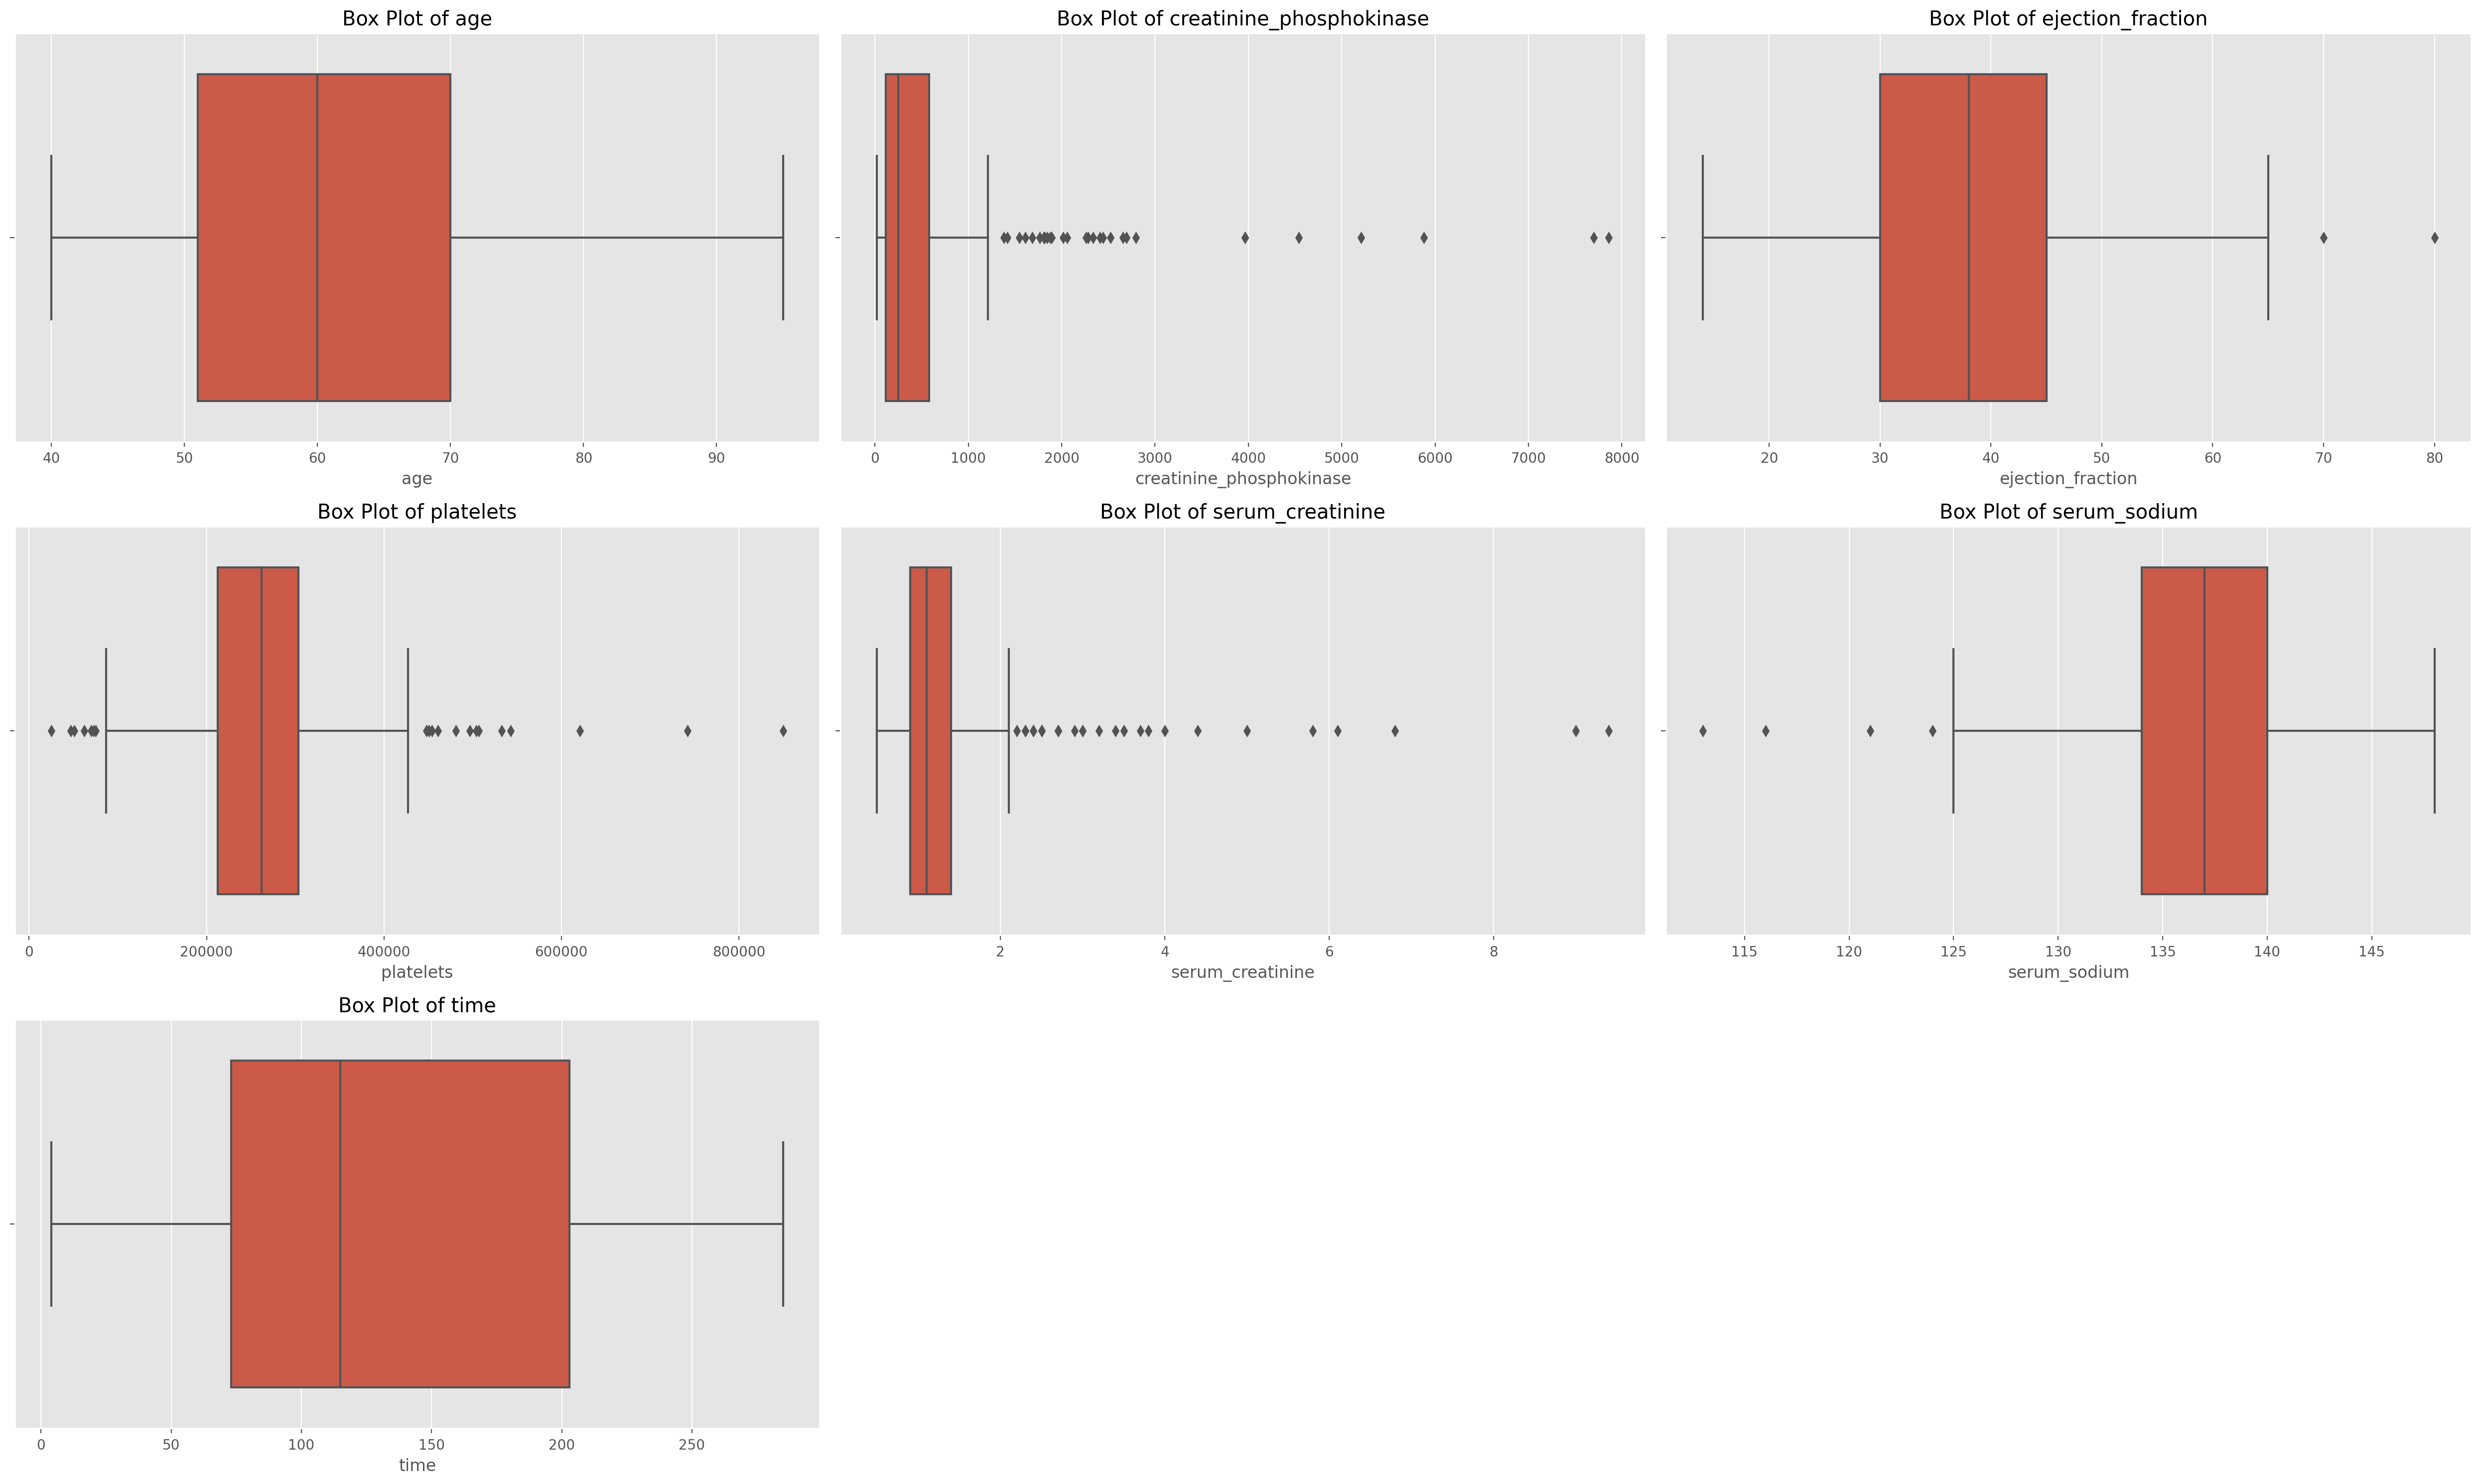

outliers  percentage
creatinine_phosphokinase        29    9.698997
serum_creatinine                29    9.698997
platelets                       21    7.023411
serum_sodium                     4    1.337793
ejection_fraction                2    0.668896
age                              0    0.000000
time                             0    0.000000

In [69]:
create_boxplot(3,3,df,num_cols)
show_outlier(df,num_cols)

We will eliminate outliers from each variable in the dataset by employing the IQR method.

In [70]:
for i in num_cols:
    q1 = np.quantile(df[i],0.25)
    q3 = np.quantile(df[i],0.75)
    
    iqr = q3 - q1
    min_iqr = q1 - (1.5 * iqr)
    max_iqr = q3 + (1.5 * iqr)

    df = df[(df[i] >= min_iqr) & (df[i] <= max_iqr)]

Let's check for the second time. As it can be seen, there's only a few outliers left, so we can move on to the next step.

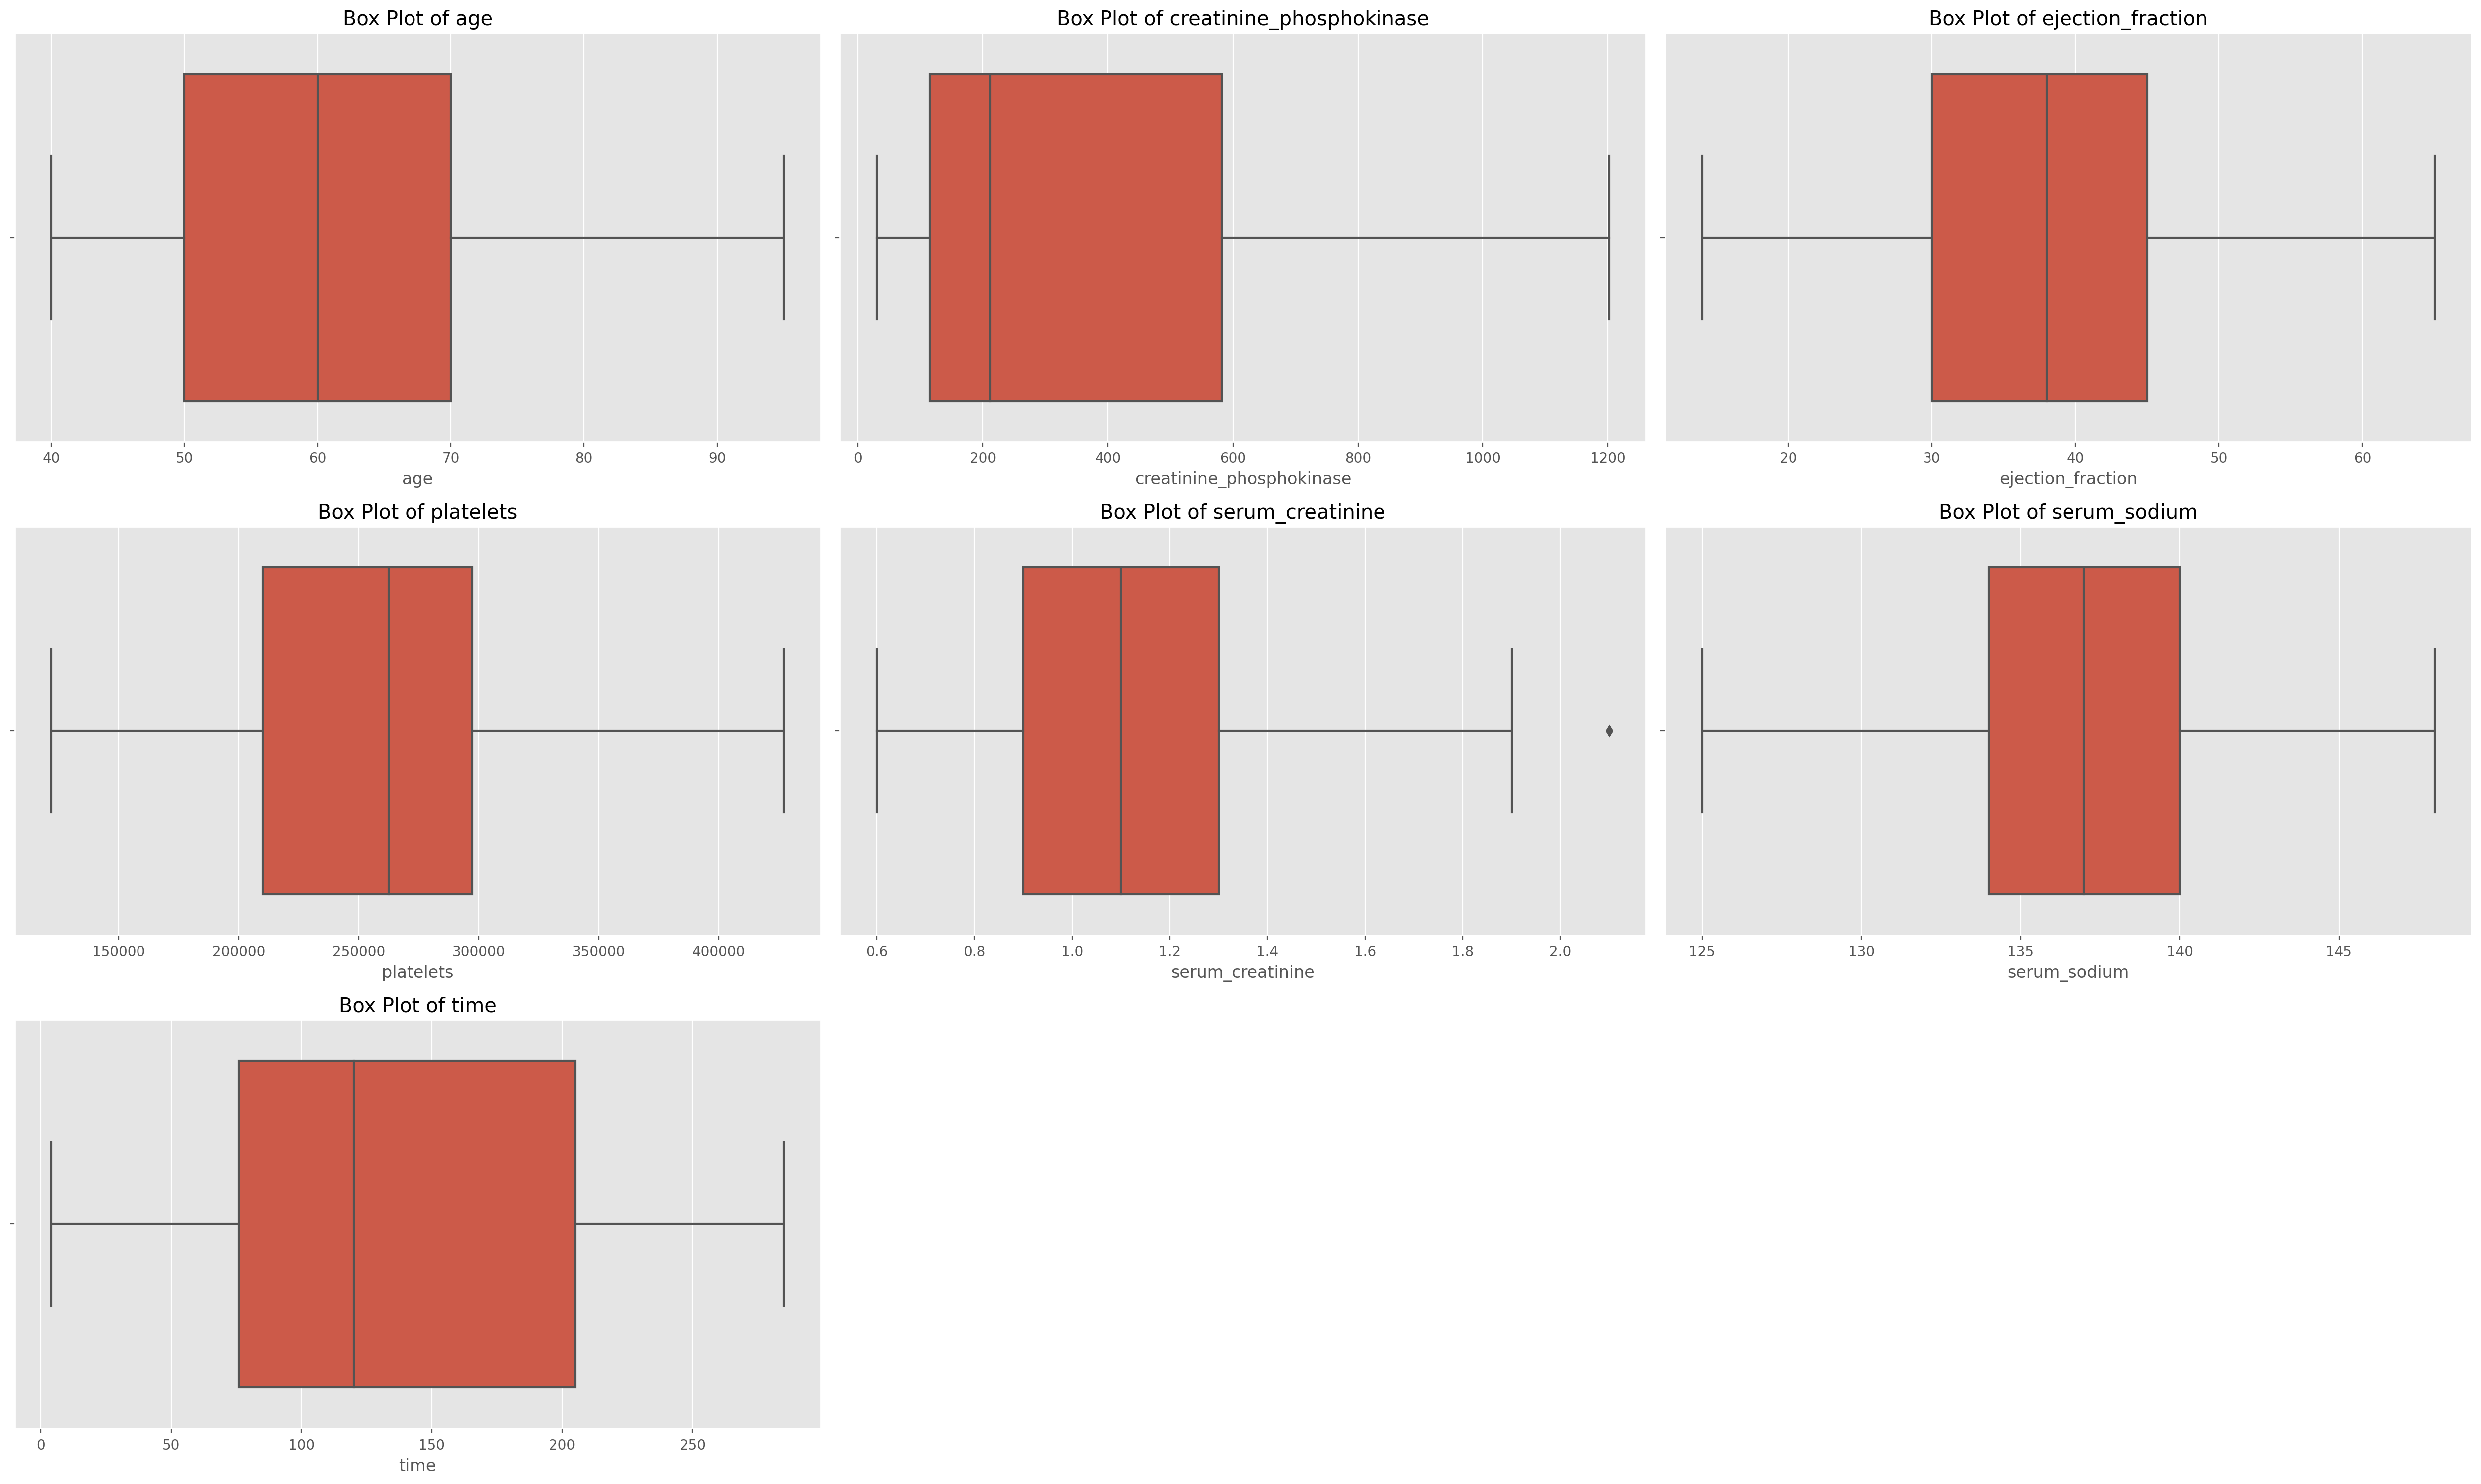

outliers  percentage
serum_creatinine                 3    1.339286
age                              0    0.000000
creatinine_phosphokinase         0    0.000000
ejection_fraction                0    0.000000
platelets                        0    0.000000
serum_sodium                     0    0.000000
time                             0    0.000000

In [71]:
create_boxplot(3,3,df,num_cols)
show_outlier(df,num_cols)

## Data Exploration Analysis

Calculate the correlation between the features and the target variable, which is "death_event." It is evident that the "time" feature has the greatest impact on the "death_event."

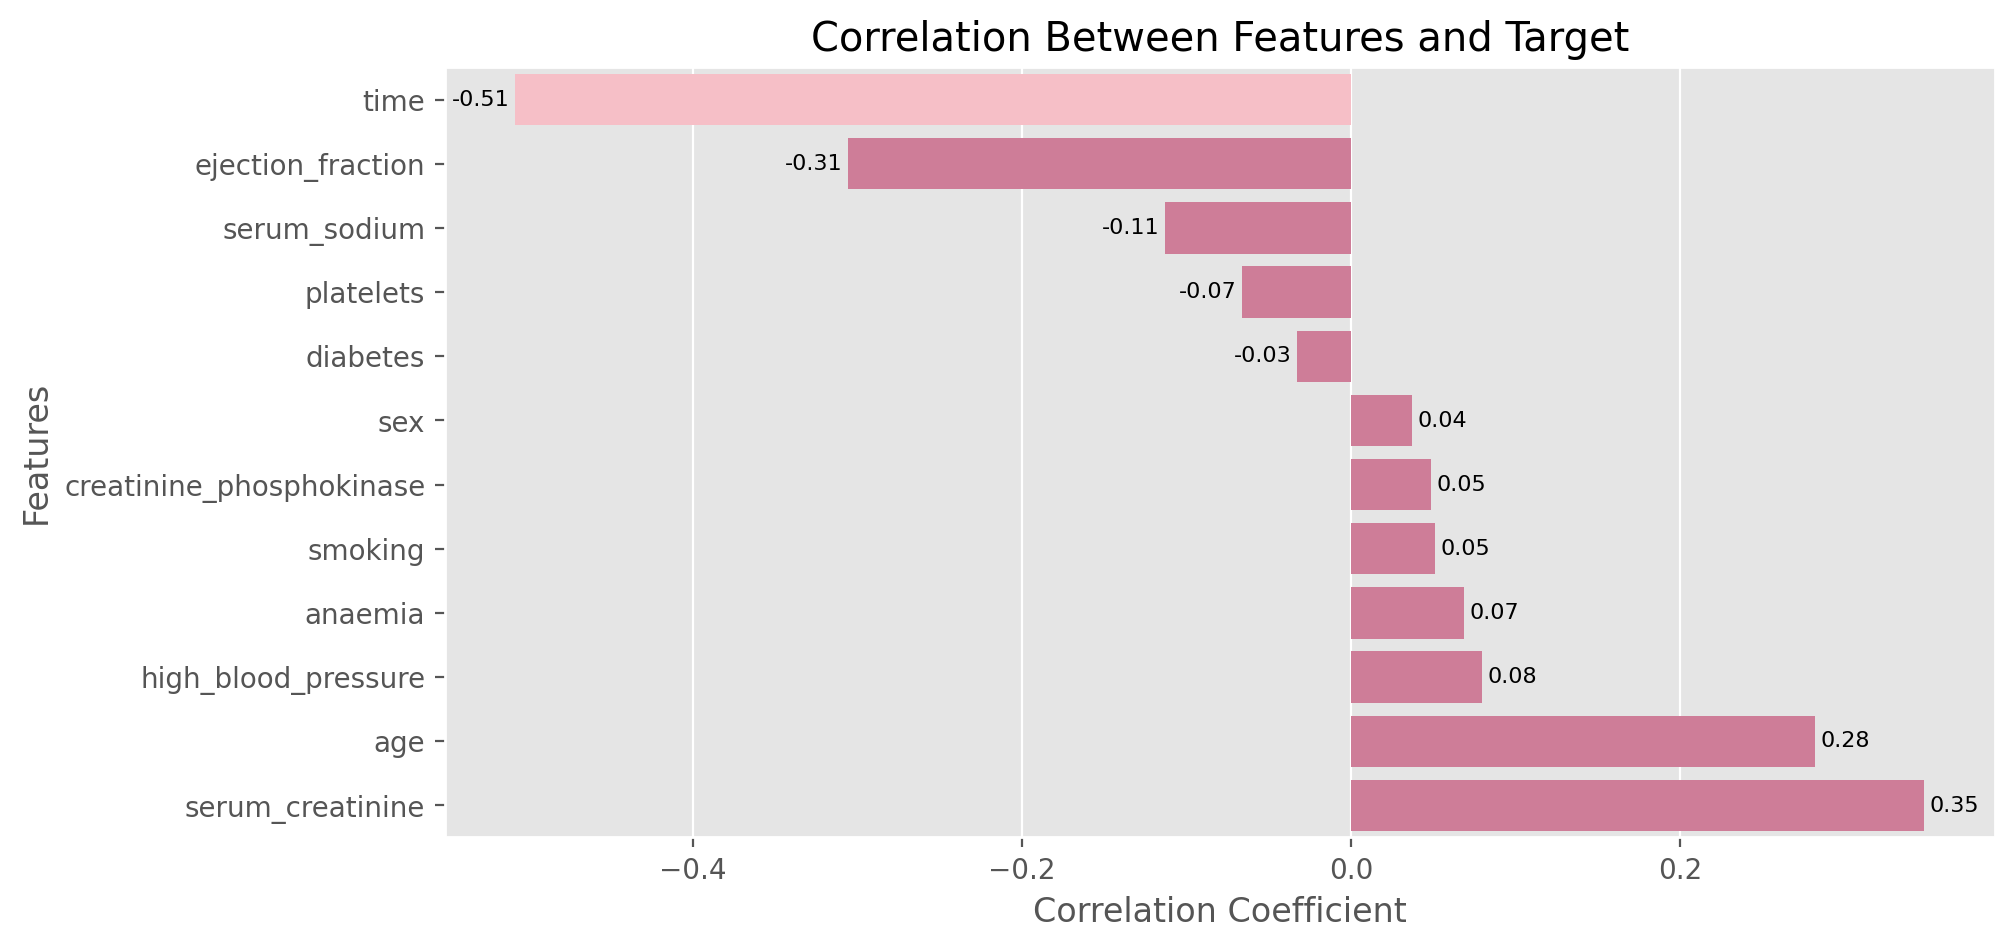

In [72]:
corr = pd.get_dummies(df).iloc[:,:-1].corr()[["death_event_Dead"]].iloc[:-1].sort_values("death_event_Dead")

plt.figure(figsize=(10,5),dpi=200)
ax = sns.barplot(
    data=corr,
    x=corr.death_event_Dead,
    y=corr.index,
    palette=["#ffb6c1" if i == np.max(abs(corr.death_event_Dead)) else "#db7093" for i in abs(corr.death_event_Dead)]
)

for container in ax.containers:
    ax.bar_label(container,fmt="%.2f",color="black",fontsize=8,padding=2)

plt.title("Correlation Between Features and Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.show()

**Conclusion**: As the duration of the follow-up period increases, the time feature exhibits a negative correlation with the death_event variable, indicating that patients are less likely to experience death.

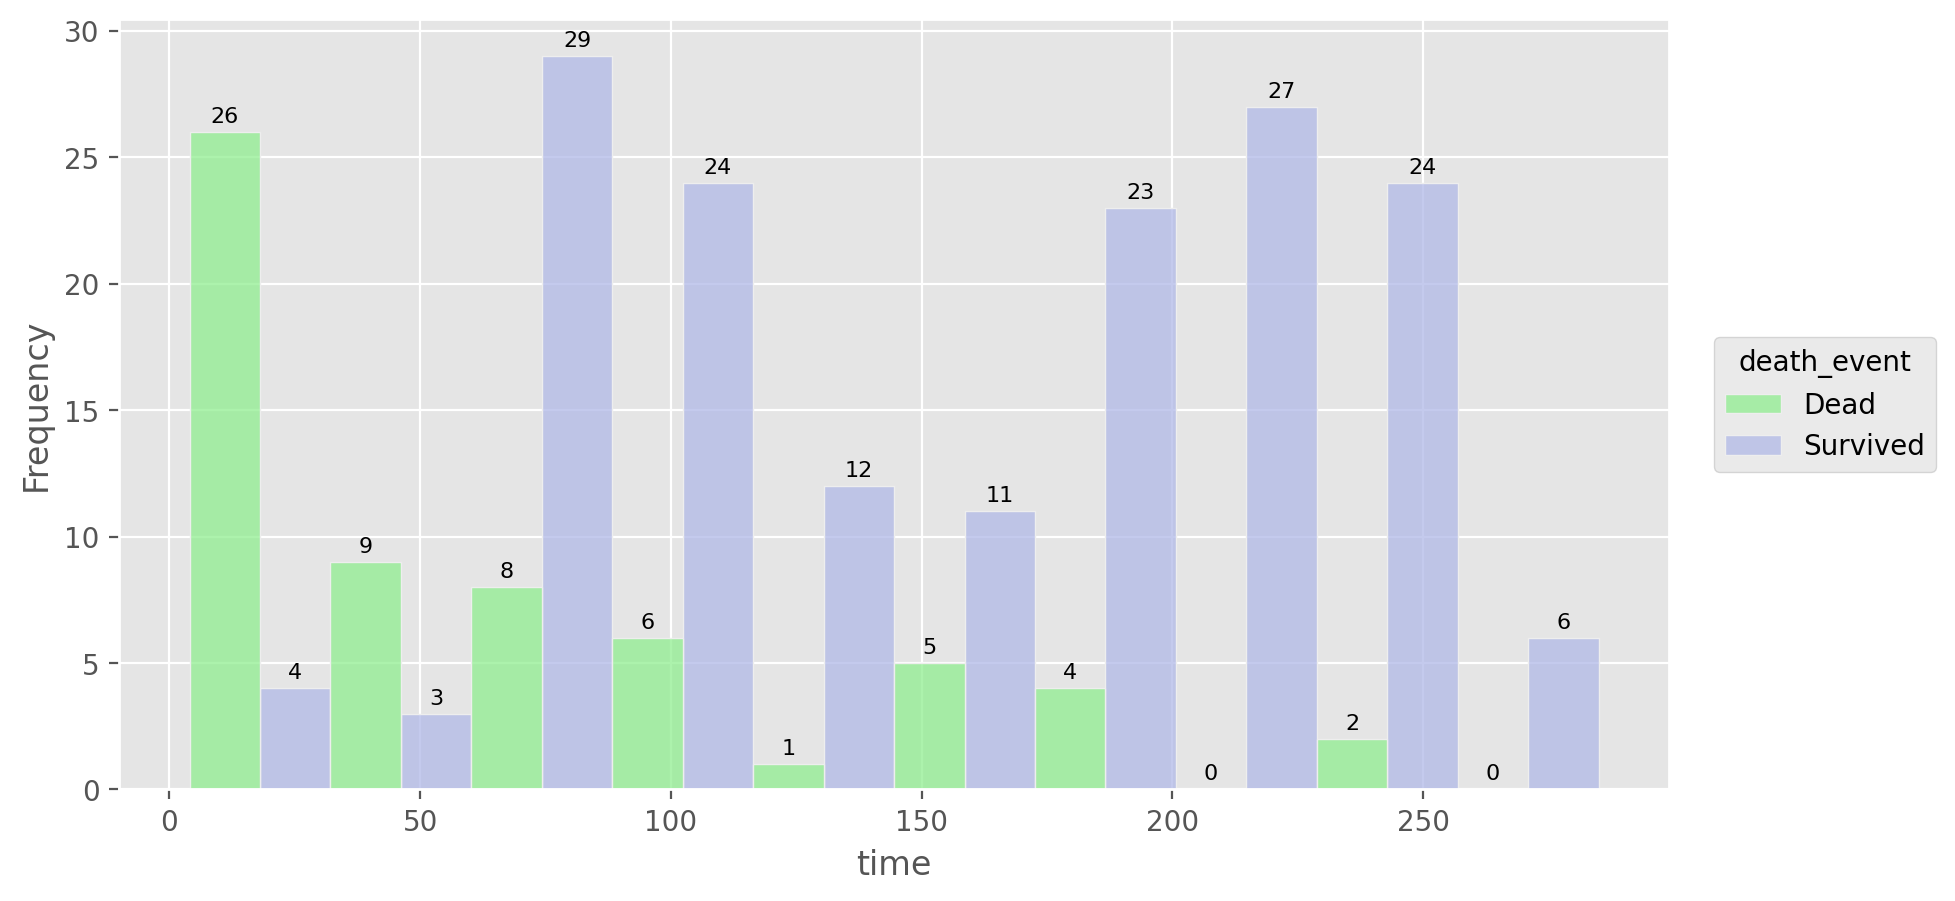

In [73]:
plt.figure(figsize=(10,5),dpi=200)
ax = sns.histplot(df,x="time",hue="death_event",palette=["#90EE90","#B1B9E7"],multiple="dodge",bins=10)

for container in ax.containers:
    ax.bar_label(container,color="black",fontsize=8,padding=2)

sns.move_legend(ax,loc="center left",bbox_to_anchor=(1.02,0.5))
plt.ylabel("Frequency")
plt.show()

**Conclusion**: Next, we will examine the two features that hold significant influence following "time," namely "ejection_fraction" and "serum_creatinine." Higher values of "ejection_fraction" and lower values of "serum_creatinine" indicate a greater likelihood of patient survival. 

To simplify the analysis, we will categorize "ejection_fraction" and "serum_creatinine" into two groups: those greater than or equal to their respective averages and those less than the averages.

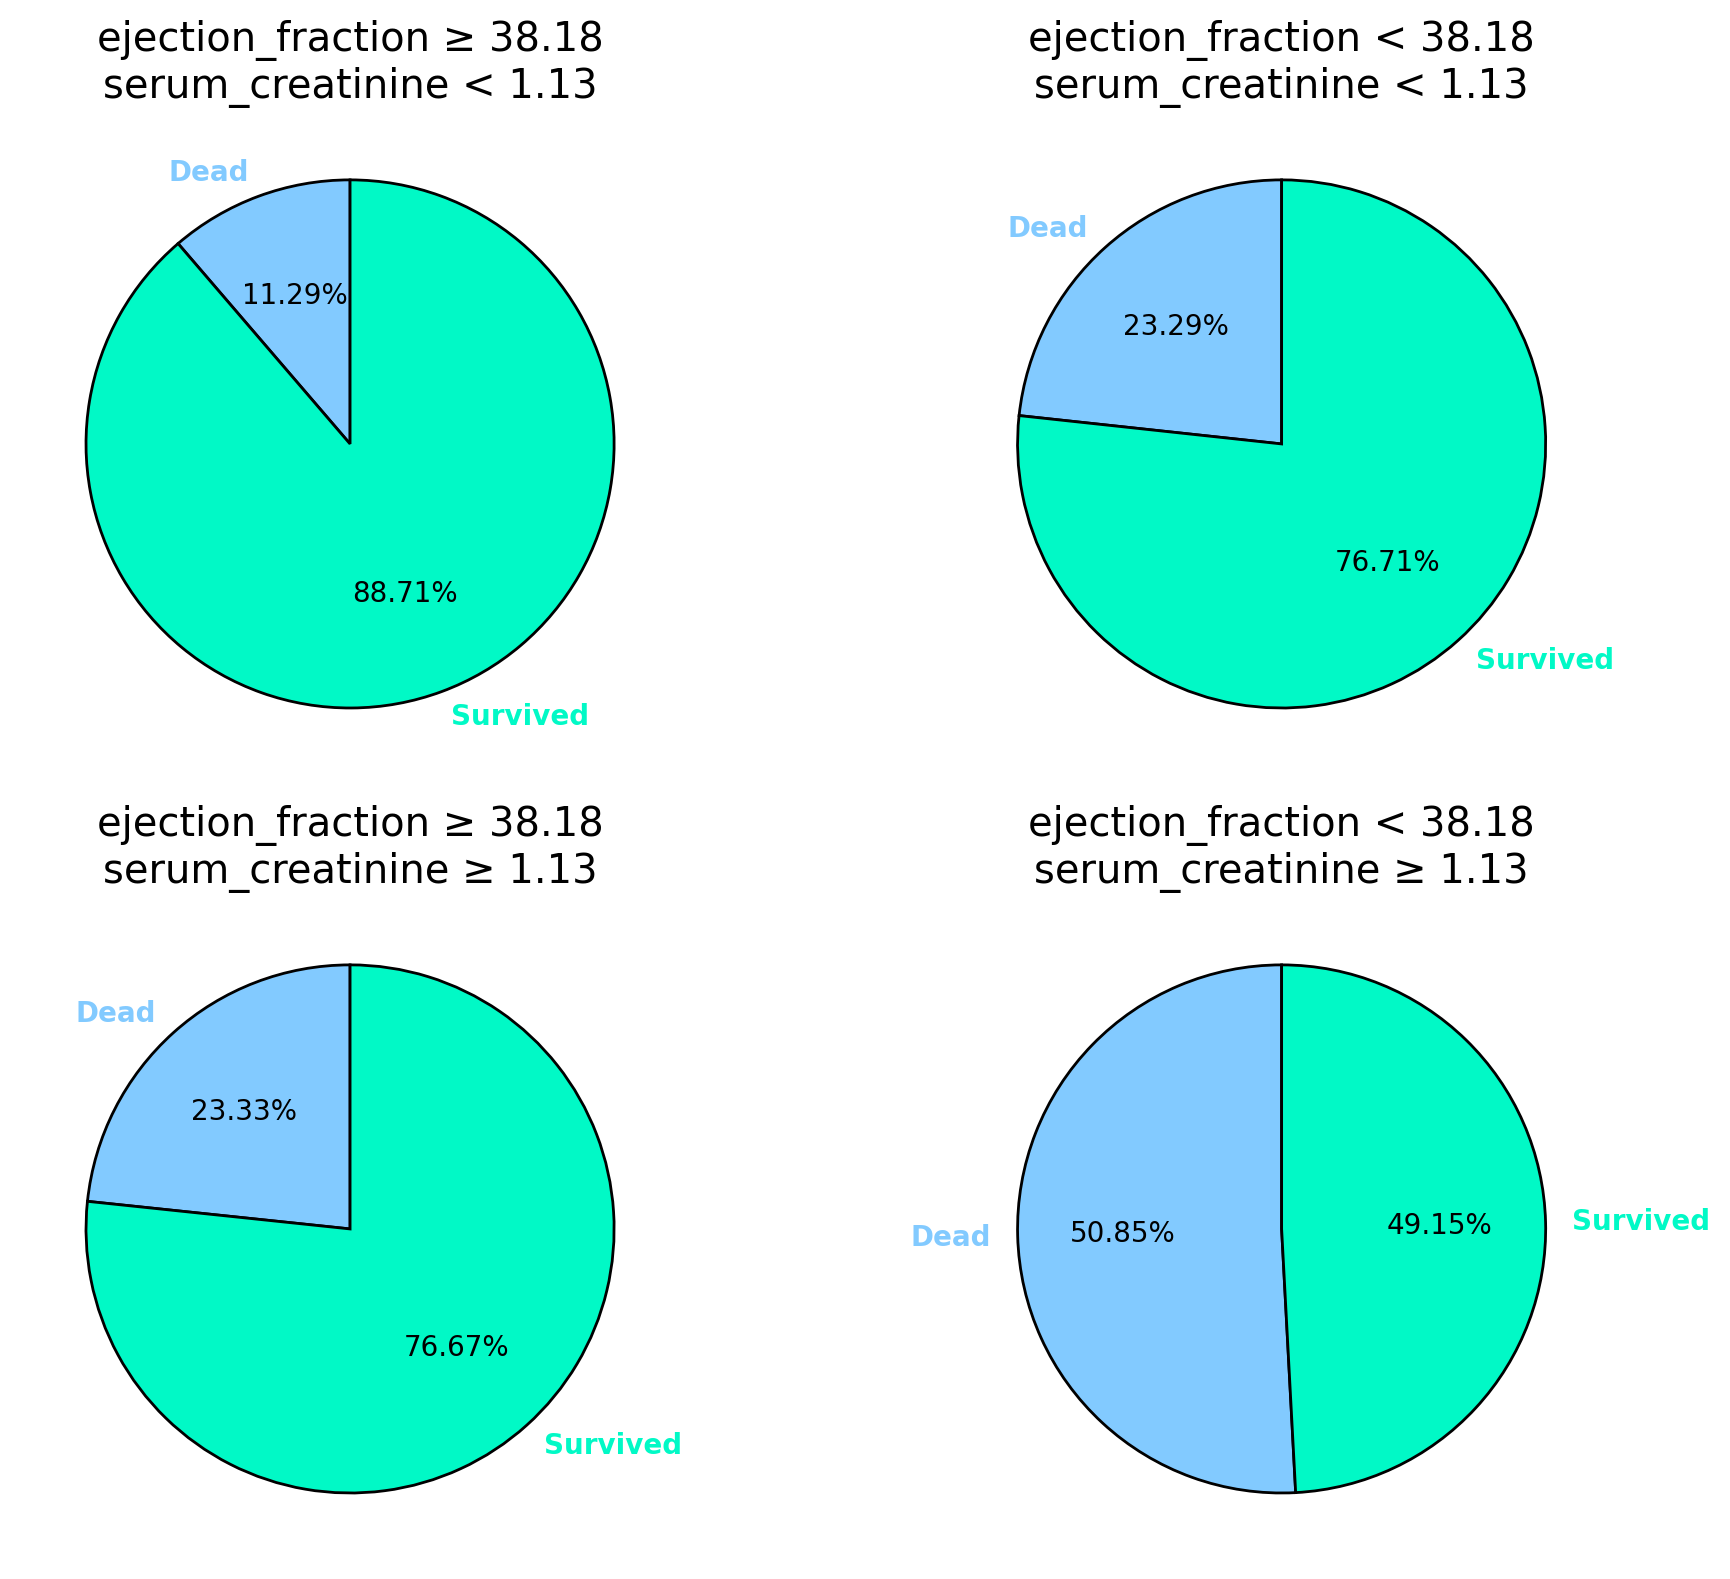

In [74]:
first = df[
    (df["ejection_fraction"] >= np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] < np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

second = df[
    (df["ejection_fraction"] < np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] < np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

third = df[
    (df["ejection_fraction"] >= np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] >= np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

fourth = df[
    (df["ejection_fraction"] < np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] >= np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

ejection_fraction_and_serum_creatinine = [first,second,third,fourth]
titles = [
    f"ejection_fraction ≥ {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine < {round(np.mean(df['serum_creatinine']),2)}",
    f"ejection_fraction < {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine < {round(np.mean(df['serum_creatinine']),2)}",
    f"ejection_fraction ≥ {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine ≥ {round(np.mean(df['serum_creatinine']),2)}",
    f"ejection_fraction < {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine ≥ {round(np.mean(df['serum_creatinine']),2)}",
]

nrows,ncols = 2,2
fig,ax = plt.subplots(nrows,ncols,figsize=(10,8),dpi=200,sharex=True,sharey=True)

n = 0
for nrow in range(nrows):
    for ncol in range(ncols):
        patches,texts,pcts = ax[nrow,ncol].pie(
            ejection_fraction_and_serum_creatinine[n].age,
            labels=ejection_fraction_and_serum_creatinine[n].index,
            startangle=90,
            colors=["#82CAFF","#01F9C6"],
            autopct="%.2f%%",
            wedgeprops={"linewidth":1.0,"edgecolor":"black"}
        )

        ax[nrow,ncol].set_title(titles[n])

        n += 1

        for index,patch in enumerate(patches):
            texts[index].set_color(patch.get_facecolor())

        plt.setp(pcts,color="black")
        plt.setp(texts,fontweight=600)

plt.tight_layout()
plt.show()

**Conclusion**: Based on information from the American Heart Association, a nonprofit organization in the U.S., a typical ejection fraction falls within the range of 50% to 75%. After removing outliers, among the 224 patients, only 20.98% of them exhibit a normal ejection fraction.

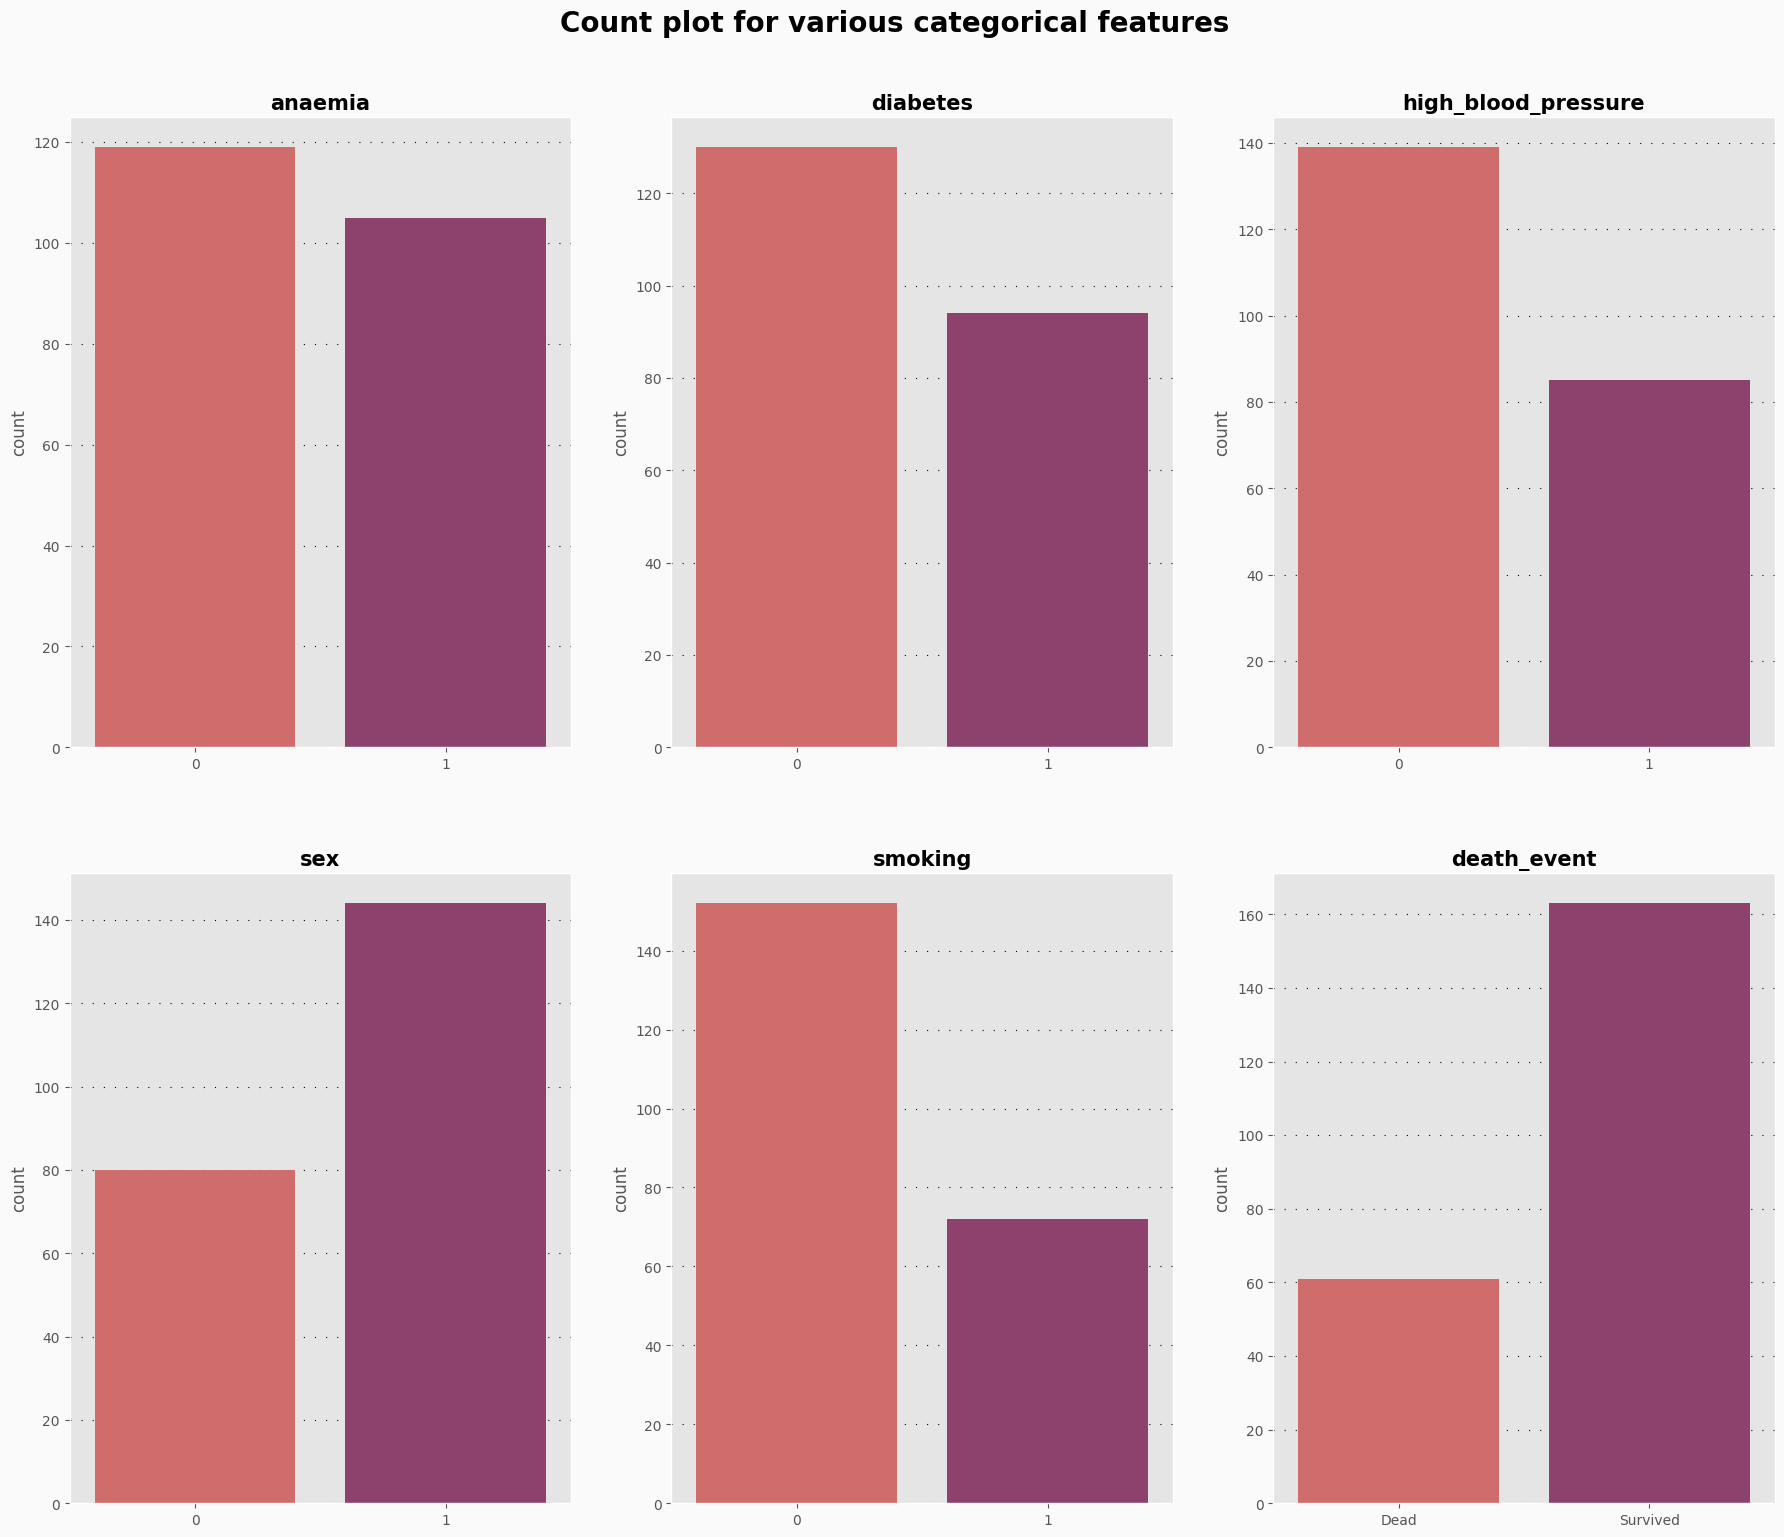

In [75]:
def plot_cate_feat(df, ax, col_name):
    ax.set_title(col_name,fontweight ="600",fontsize=15)
    ax.grid(color='#000000', linestyle='dashed', axis='y',dashes=(1,9))
    sns.countplot(ax=ax,data=df,x=col_name,palette = "flare")
    ax.set_xlabel("")

fig = plt.figure(figsize=(22,18))
gs  = fig.add_gridspec(2,3)
axes = []

for i in range(2): # 0, 1
    for j in range(3): # 0, 1, 2
        ax = fig.add_subplot(gs[i,j])
        axes.append(ax)


fig.suptitle(t='Count Plot for Various Categorical Features',y=0.94, fontweight ="600",fontsize=20)
fig.set_facecolor("#fafafa")

for ax,col_name in zip(axes,cat_cols):
    plot_cate_feat(df, ax, col_name)


plt.show()

**Conclusion**: Then it can be seen the spread of the distribution of categories in each categorical feature in the dataset.

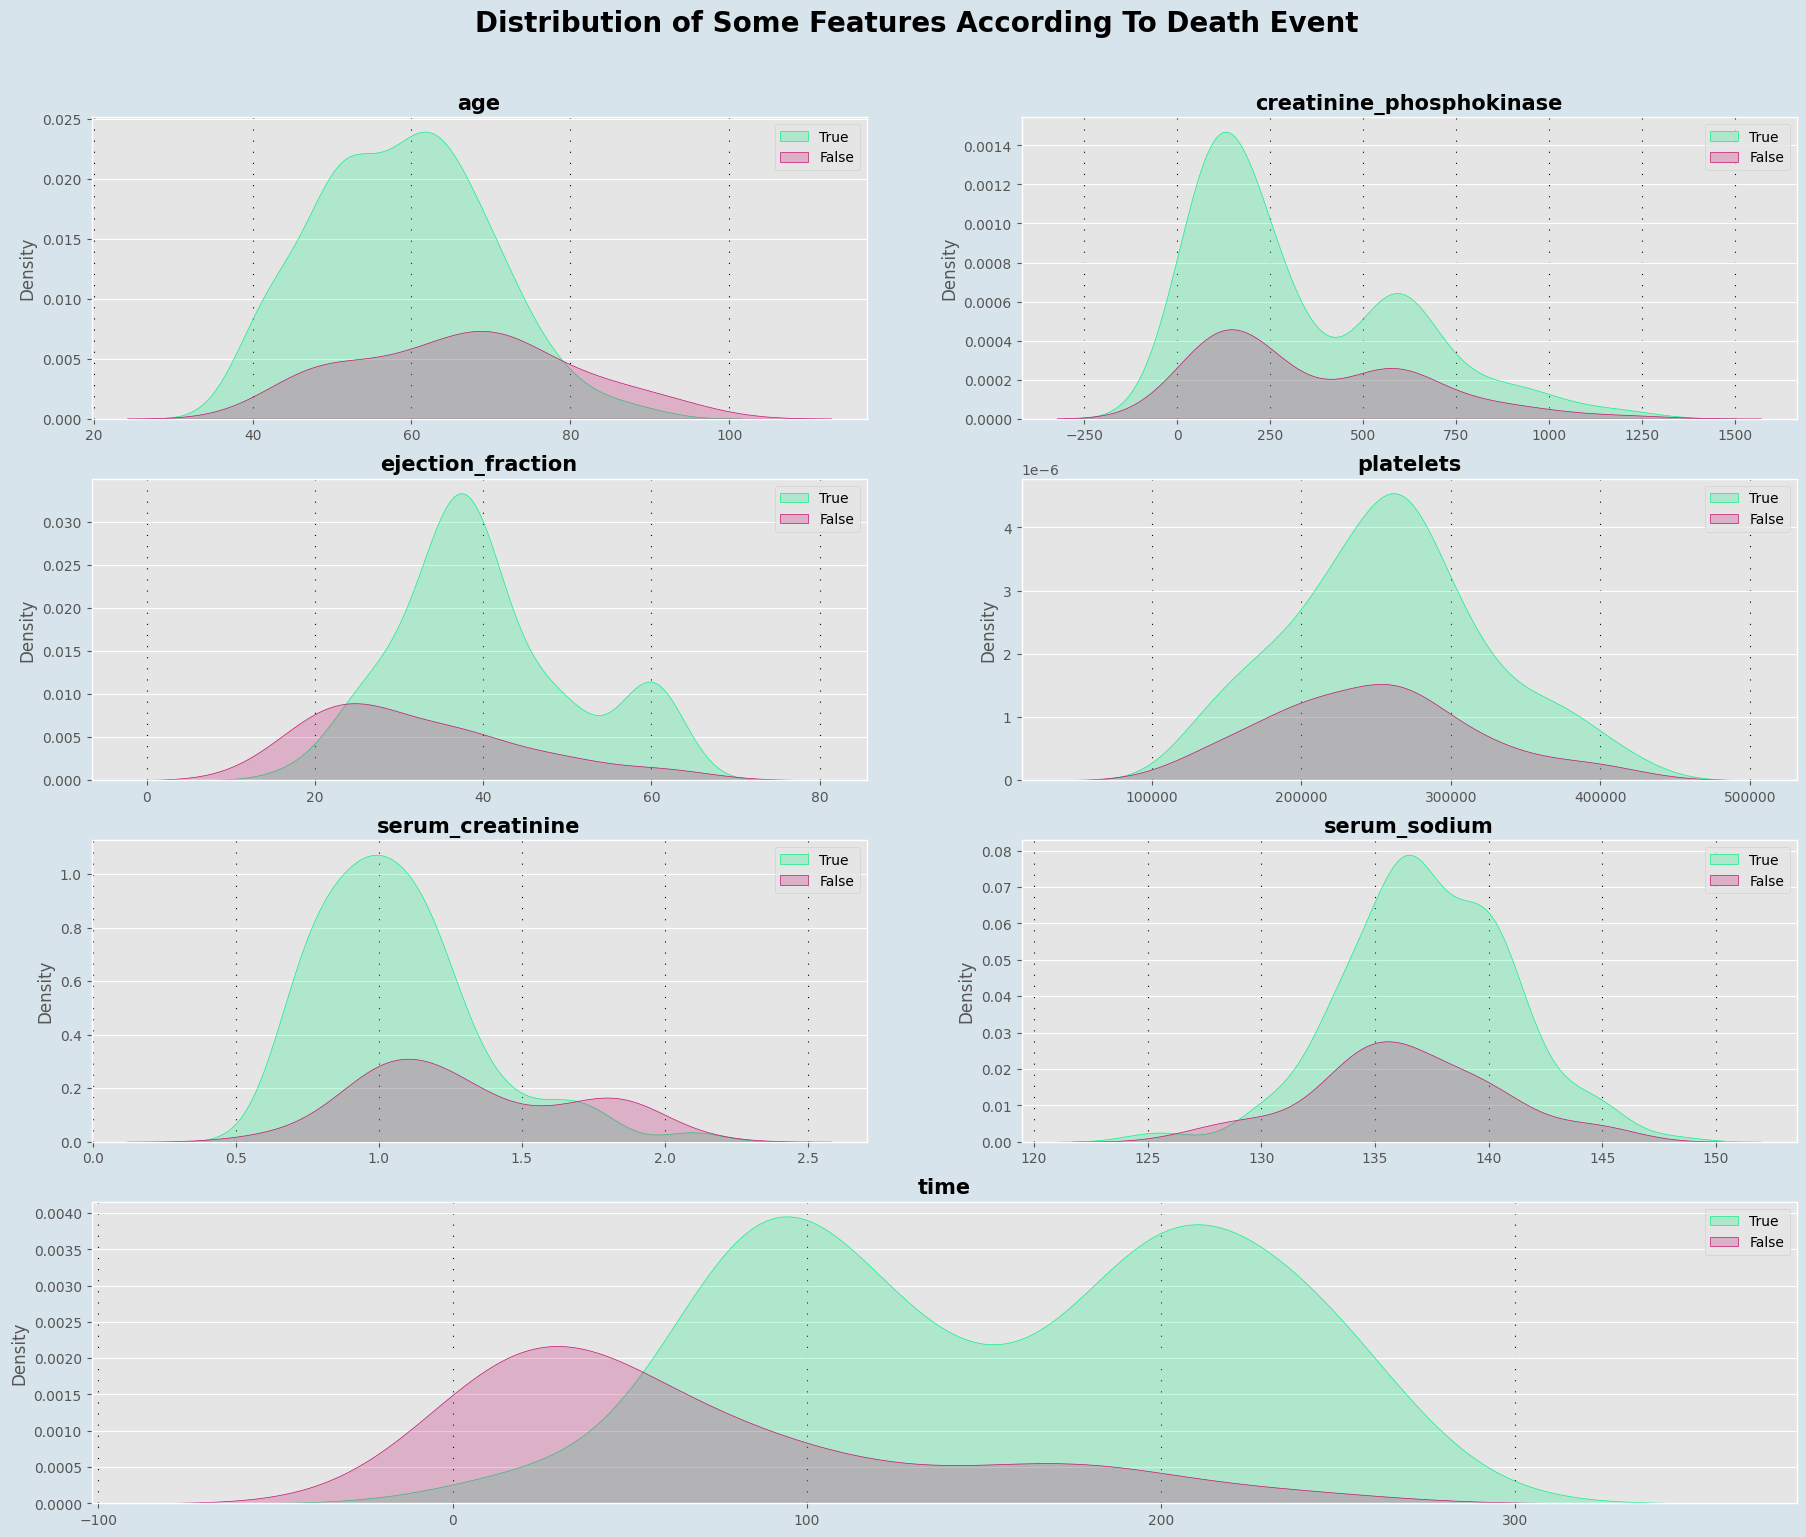

In [96]:
def plot_con_feat(df, ax, col_name, target='death_event'):
    ax.set_title(col_name,fontweight ="600",fontsize=15)
    ax.grid(color='#000000', linestyle='dashed', axis='x',dashes=(1,9))
    sns.kdeplot(ax=ax,data=df,x=col_name, hue=target, fill=True, palette = ['#c4146f','#0cf085'])
    ax.legend([True, False])
    ax.set_xlabel("")

fig = plt.figure(figsize=(22,18))
gs  = fig.add_gridspec(4,2)
axes = []

for i in range(4):
    for j in range(2):
        if i<3:
            ax = fig.add_subplot(gs[i,j])
            axes.append(ax)
        else:
            ax = fig.add_subplot(gs[i,:])
            axes.append(ax)
            break


fig.suptitle(t='Distribution of Some Features According To Death Event',y=0.94, fontweight ="bold",fontsize=20)
fig.set_facecolor("#d8e4eb")


for ax,col_name in zip(axes,num_cols):
    plot_con_feat(df, ax, col_name)

plt.show()

**Conclusion**: From the distribution of some features according to death event, the distribution in the "True" section has a dominant value compared to the "False" distribution

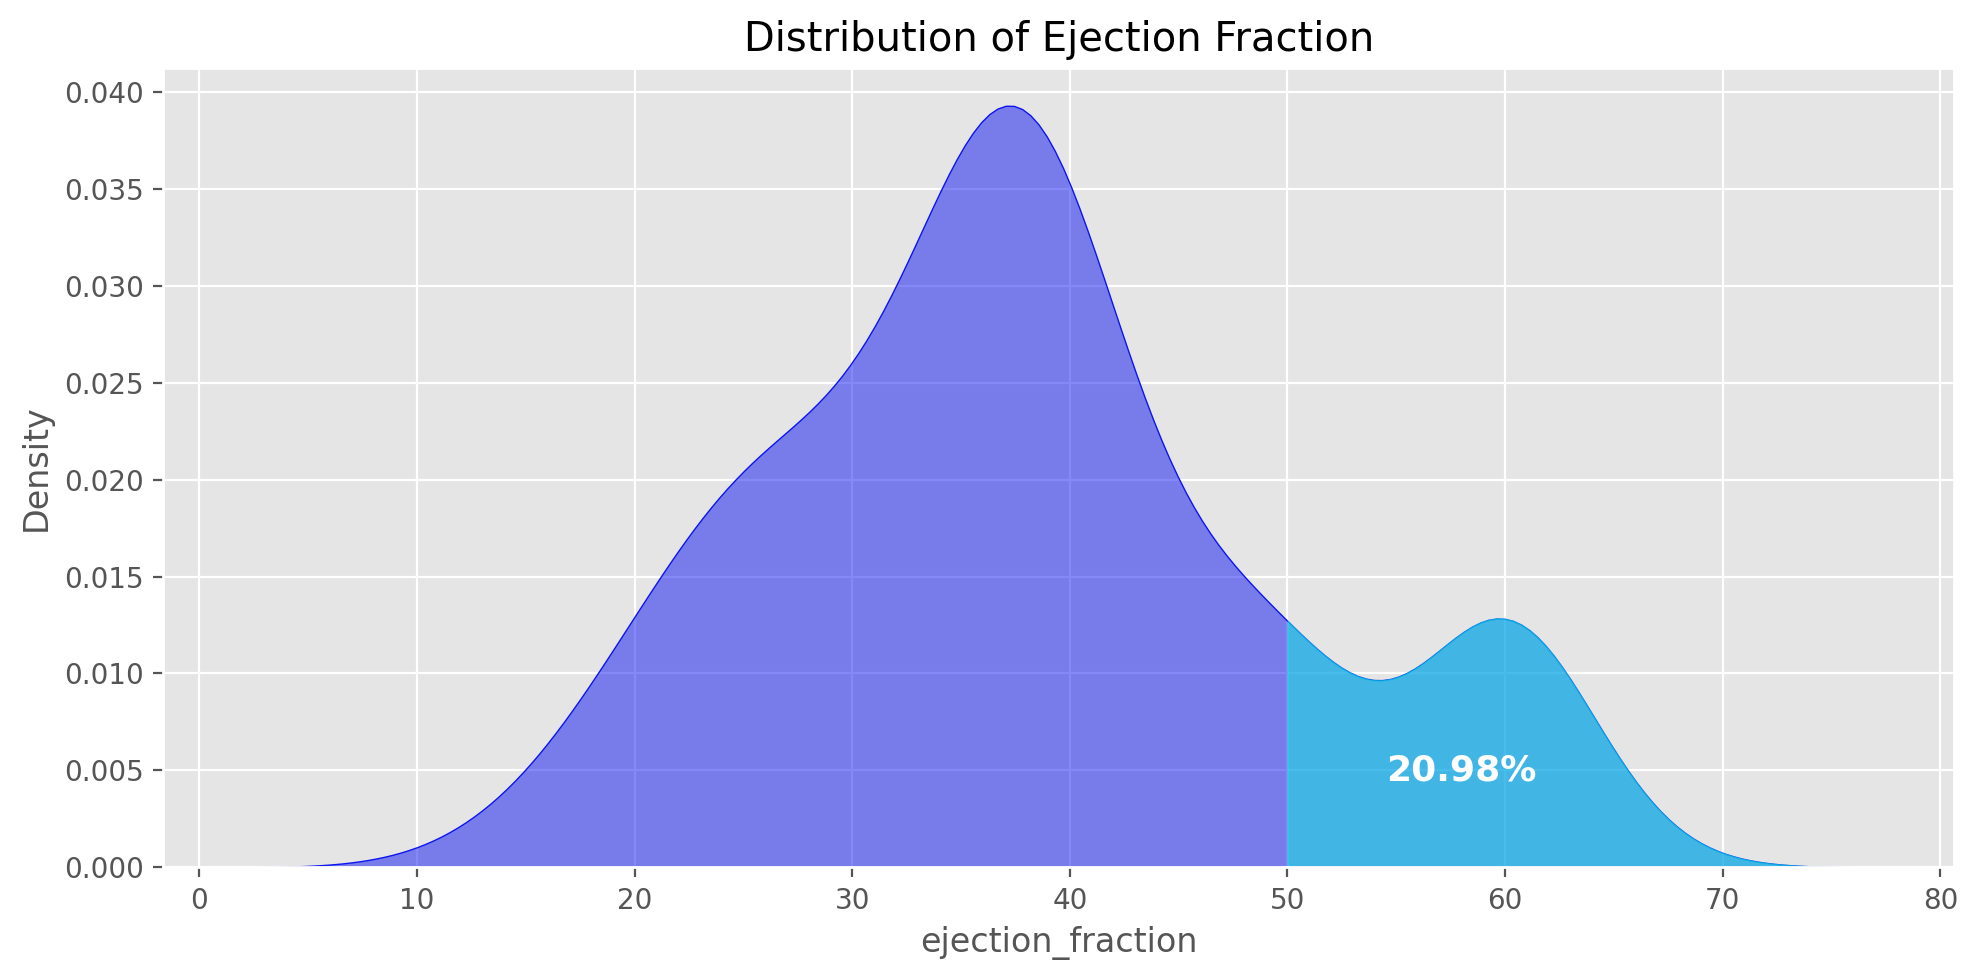

In [97]:
fig,ax = plt.subplots(figsize=(10,5),dpi=200)

kde_ejection_fraction = sns.kdeplot(ax=ax,data=df,x="ejection_fraction",color="#0c14f0",fill=True,alpha=0.5)
xmin,xmax = kde_ejection_fraction.get_xlim()
kde = gaussian_kde(df["ejection_fraction"])
x = np.linspace(xmin,xmax,10_000)
kde_y = kde(x)

x0,y0 = [],[]
for i,j in zip(x,kde_y):
    if (i >= 50) & (i <= 75):
        x0.append(i)
        y0.append(j)
x0,y0 = np.array(x0),np.array(y0)

area0 = round(simps(y0,x0,dx=1) * 100,0)
kde_ejection_fraction.fill_between(x=x0,y1=y0,color="#0cf0e1",alpha=0.5)

ax.set_title("Distribution of Ejection Fraction")
ax.set_xlim(xmin,xmax)
ax.text(
    x=58,
    y=0.0045,
    s=f"{round(len(df[(df['ejection_fraction'] >= 50) & (df['ejection_fraction'] <= 75)]) / len(df) * 100,2)}%",
    horizontalalignment="center",
    color="white",
    fontweight="bold",
    fontsize=13
)

plt.tight_layout()
plt.show()

**Conclusion**: As stated by Mayo Clinic, a nonprofit American academic medical center, the usual range for serum creatinine in adult men is 0.74 to 1.35 mg/dL, while in adult women, it is 0.59 to 1.04 mg/dL. 

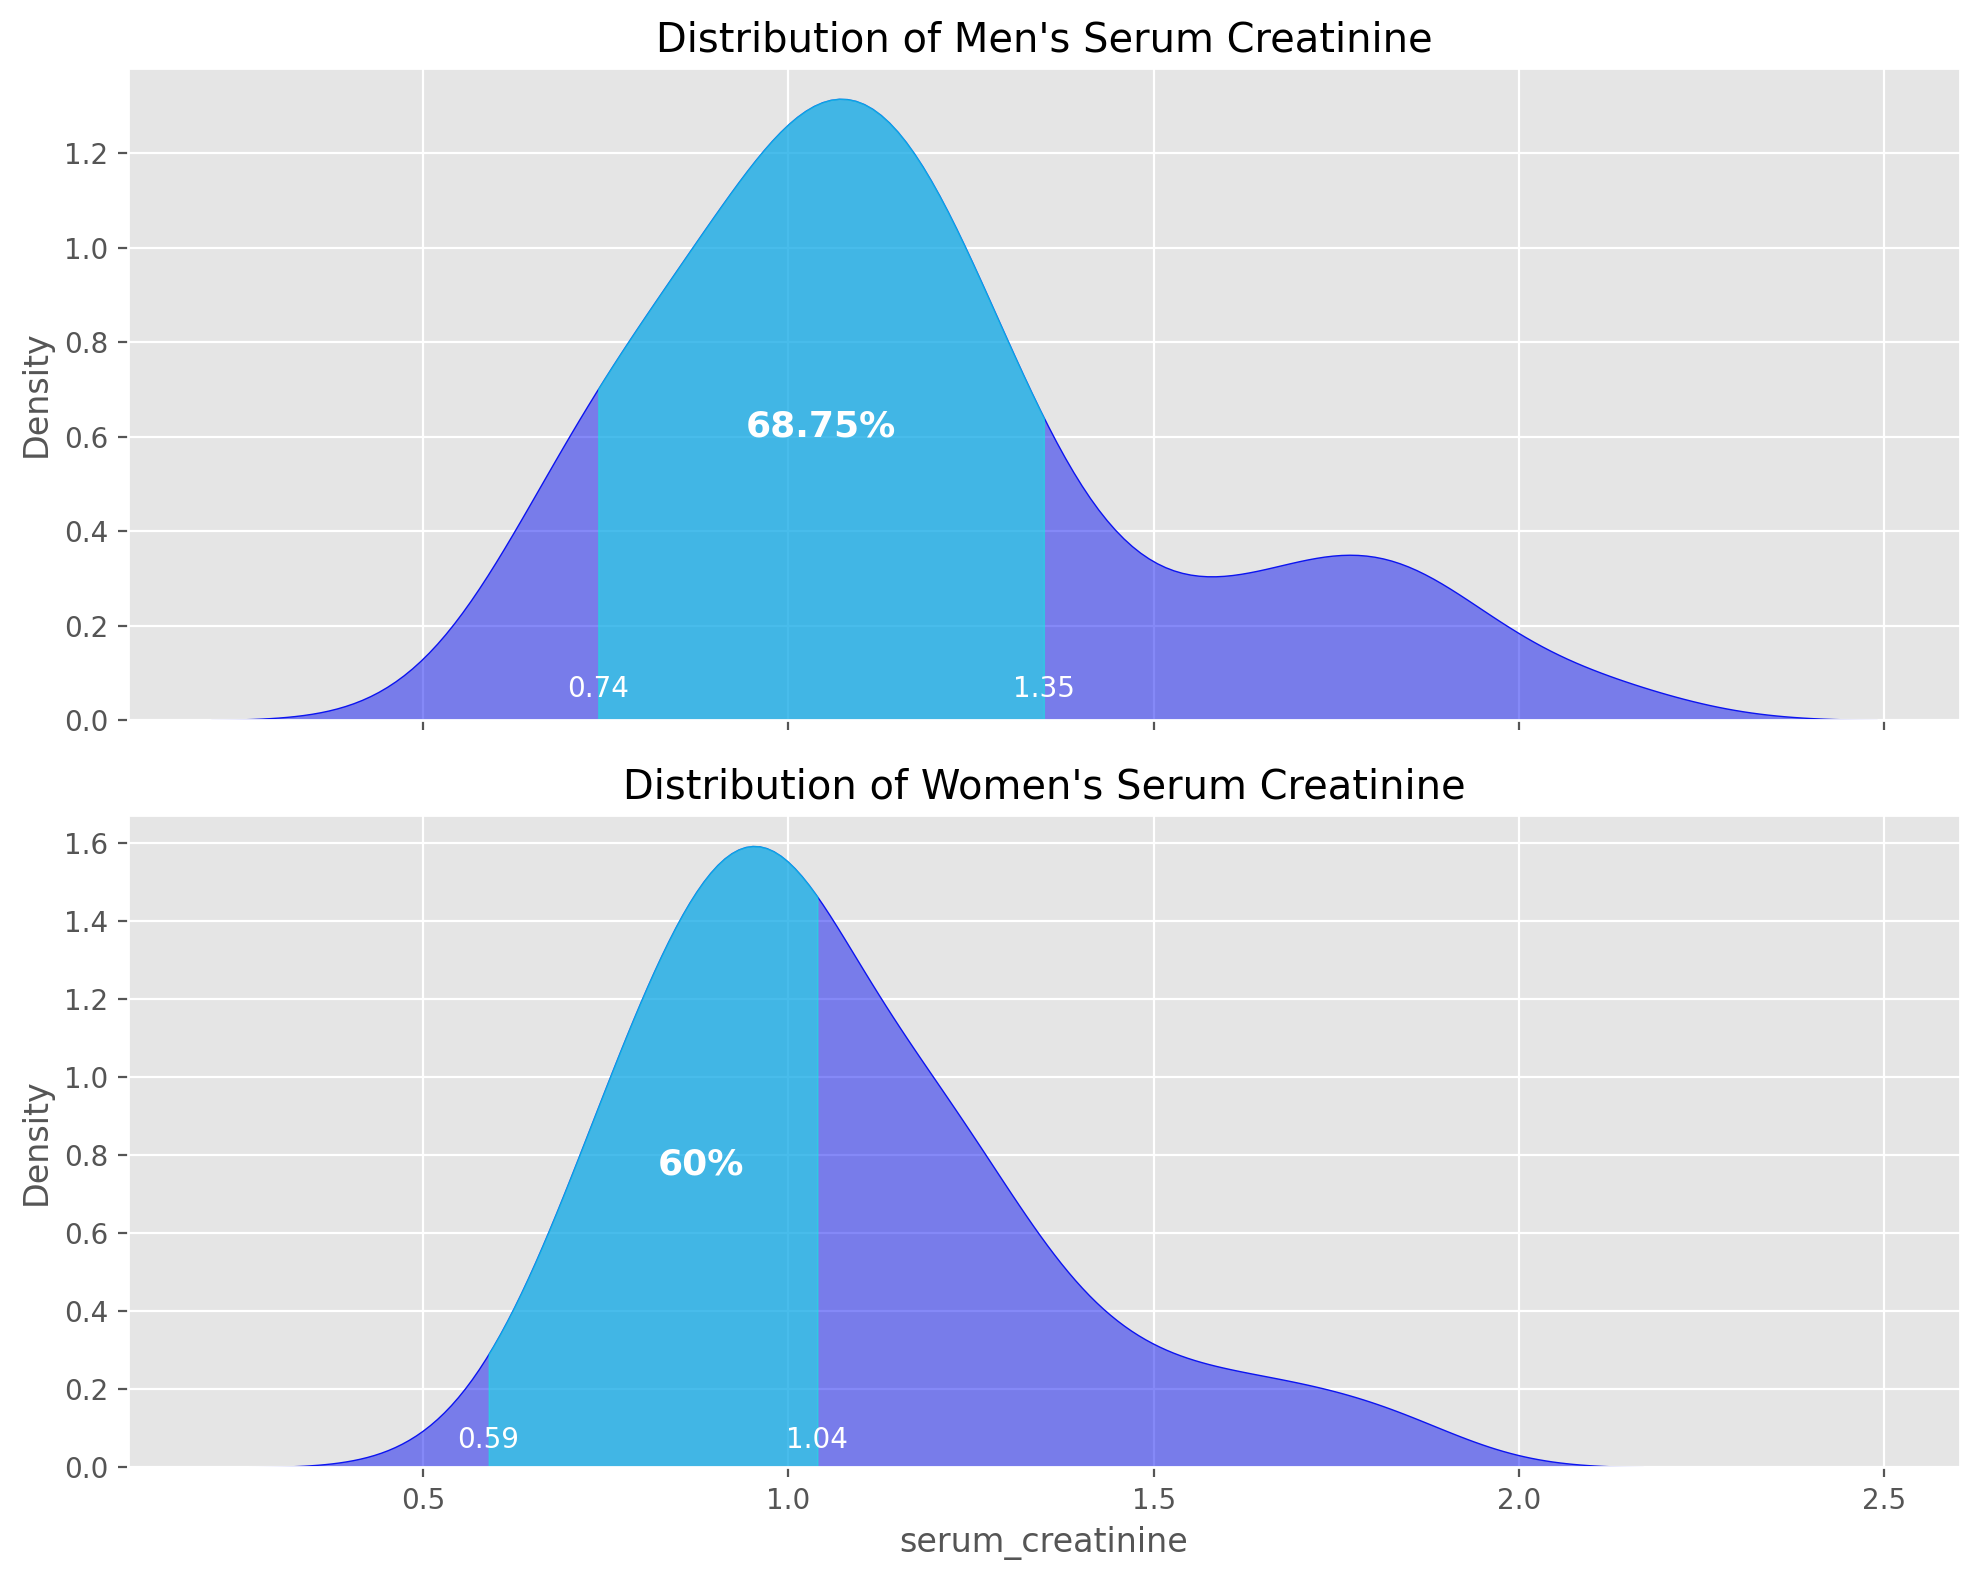

In [98]:
fig,ax = plt.subplots(2,1,figsize=(10,8),dpi=200,sharex=True)

for nrow,lower,upper,sex,title in zip(range(2),[0.74,0.59],[1.35,1.04],[1,0],["Men","Women"]):
    kde_serum_creatinine = sns.kdeplot(ax=ax[nrow],data=df[df["sex"] == sex],x="serum_creatinine",color="#0c14f0",fill=True,alpha=0.5)
    xmin,xmax = kde_serum_creatinine.get_xlim()
    kde = gaussian_kde(df[df["sex"] == sex]["serum_creatinine"])
    x = np.linspace(xmin,xmax,10_000)
    kde_y = kde(x)

    x0,y0 = [],[]
    for i,j in zip(x,kde_y):
        if (i >= lower) & (i <= upper):
            x0.append(i)
            y0.append(j)
    x0,y0 = np.array(x0),np.array(y0)

    area0 = round(simps(y0,x0,dx=1) * 100,0)
    kde_serum_creatinine.fill_between(x=x0,y1=y0,color="#0cf0e1",alpha=0.5)

    ax[nrow].set_title(f"Distribution of {title}'s Serum Creatinine")

    for tick in [lower,upper]:
        ax[nrow].text(x=tick,y=0.05,s=tick,horizontalalignment="center",color="white",fontweight=500)

ax[0].text(
    x=0.74 + ((1.35 - 0.74) / 2),
    y=0.6,
    s=f"{len(df[(df['sex'] == 1) & (df['serum_creatinine'] >= 0.74) & (df['serum_creatinine'] <= 1.35)]) / len(df[df['sex'] == 1]) * 100}%",
    horizontalalignment="center",
    color="white",
    fontweight="bold",
    fontsize=13
)

ax[1].text(
    x=0.88,
    y=0.75,
    s=f"{int(len(df[(df['sex'] == 0) & (df['serum_creatinine'] >= 0.59) & (df['serum_creatinine'] <= 1.04)]) / len(df[df['sex'] == 0]) * 100)}%",
    horizontalalignment="center",
    color="white",
    fontweight="bold",
    fontsize=13
)

plt.tight_layout()
plt.show()

**Conclusion**: Among the 144 male patients, approximately 68.75% of them have serum creatinine levels within this range. Similarly, for the 80 female patients, around 60% of them exhibit serum creatinine values within the specified ranges.

## Data Preprocessing

Define features as X and target as y.

In [79]:
X = df.drop("death_event",axis=1)
y = df["death_event"]

To perform the train-test split on the dataset, we will divide it into 80% training data and 20% testing data. The use of the random_state parameter guarantees consistent train-test splits across different runs. It's important to note that the value assigned to random_state, such as 62, is arbitrary and can be any desired number to ensure the same train-test split.

In [80]:
random_state = 62
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

print(f"Training dataset\t: {len(X_train)}\t({round(len(X_train) / len(X) * 100)}%)")
print(f"Testing dataset\t\t: {len(X_test)}\t({round(len(X_test) / len(X) * 100)}%)")

Training dataset	: 179	(80%)
Testing dataset		: 45	(20%)


Considering the presence of an imbalanced dataset, various approaches can be employed to address this issue. One commonly used strategy is to either oversample the minority class or undersample the majority class. However, to achieve a more effective balance, researchers often recommend combining both oversampling and undersampling methods. In this study, we will compare the outcomes of the following techniques with the baseline Random Forest and Gradient Boosting models:

1. Random Oversampling
2. SMOTE Oversampling
3. Random Undersampling
4. NearMiss Undersampling
5. SMOTE combined with Tomek Links
6. SMOTE combined with Edited Nearest Neighbor

By comparing the results of these methods, we can evaluate their effectiveness in mitigating the imbalanced nature of the dataset.

It is crucial to emphasize that the resampling methods are applied exclusively to the training dataset, ensuring that the testing dataset remains unaffected and unchanged. This approach ensures the integrity of the testing dataset and allows for an accurate evaluation of model performance on unseen data.

In [81]:
# Random Oversampling
ros = RandomOverSampler(random_state=random_state)
X_train_ros,y_train_ros = ros.fit_resample(X_train,y_train)

# SMOTE Oversampling
smote = SMOTE(random_state=random_state)
X_train_smote,y_train_smote = smote.fit_resample(X_train,y_train)

# Random Undersampling
rus = RandomUnderSampler(random_state=random_state)
X_train_rus,y_train_rus = rus.fit_resample(X_train,y_train)

# NearMiss Undersampling
nearmiss = NearMiss(version=3)
X_train_nearmiss,y_train_nearmiss = nearmiss.fit_resample(X_train,y_train)

# SMOTE + Tomek Links
smotetomek = SMOTETomek(random_state=random_state)
X_train_smotetomek,y_train_smotetomek = smotetomek.fit_resample(X_train,y_train)

# SMOTE + Edited Nearest Neighbors
smoteenn = SMOTEENN(random_state=random_state)
X_train_smoteenn,y_train_smoteenn = smoteenn.fit_resample(X_train,y_train)

To visualize the dataset, we will select two random numerical features and create a scatter plot. The scatter plot reveals that the majority of the dataset corresponds to the "Survived" class, while only a small portion of the dataset corresponds to the "Dead" class.

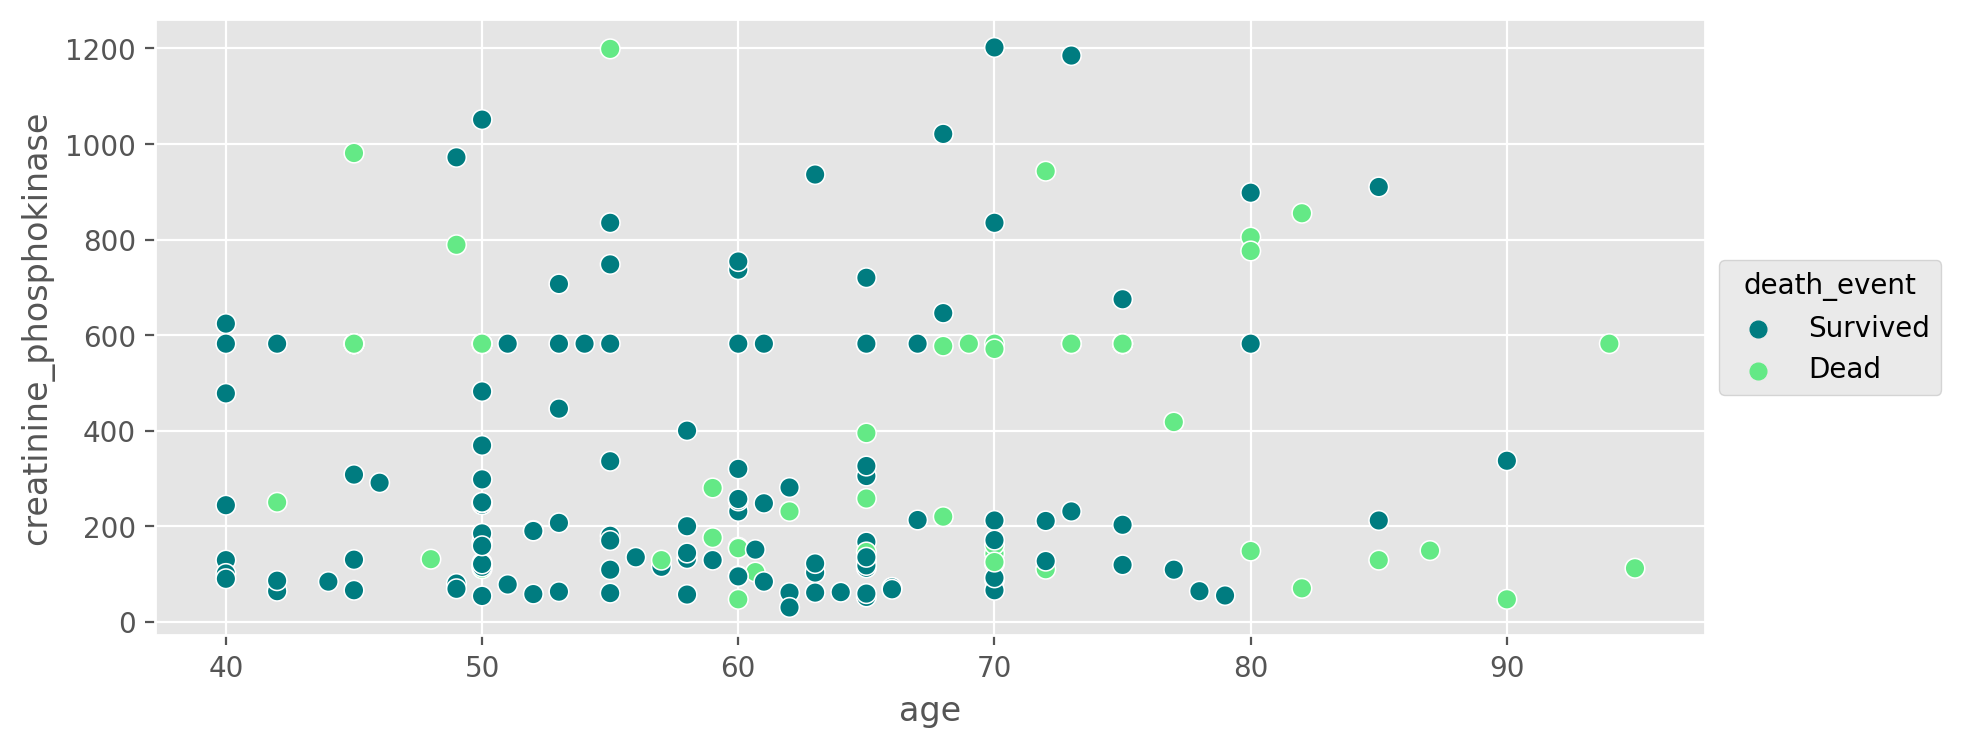

In [82]:
plt.figure(figsize=(10,4),dpi=200)
ax = sns.scatterplot(
    data=pd.concat([X_train,y_train],axis=1),
    x="age",
    y="creatinine_phosphokinase",
    hue="death_event",
    palette=["#007C80", "#64E986"],
    s=50
)
plt.legend(bbox_to_anchor=(1,0.5),loc="center left",title="death_event")

plt.show()

Following the application of resampling methods to the dataset, it becomes evident that the dataset exhibits improved balance.

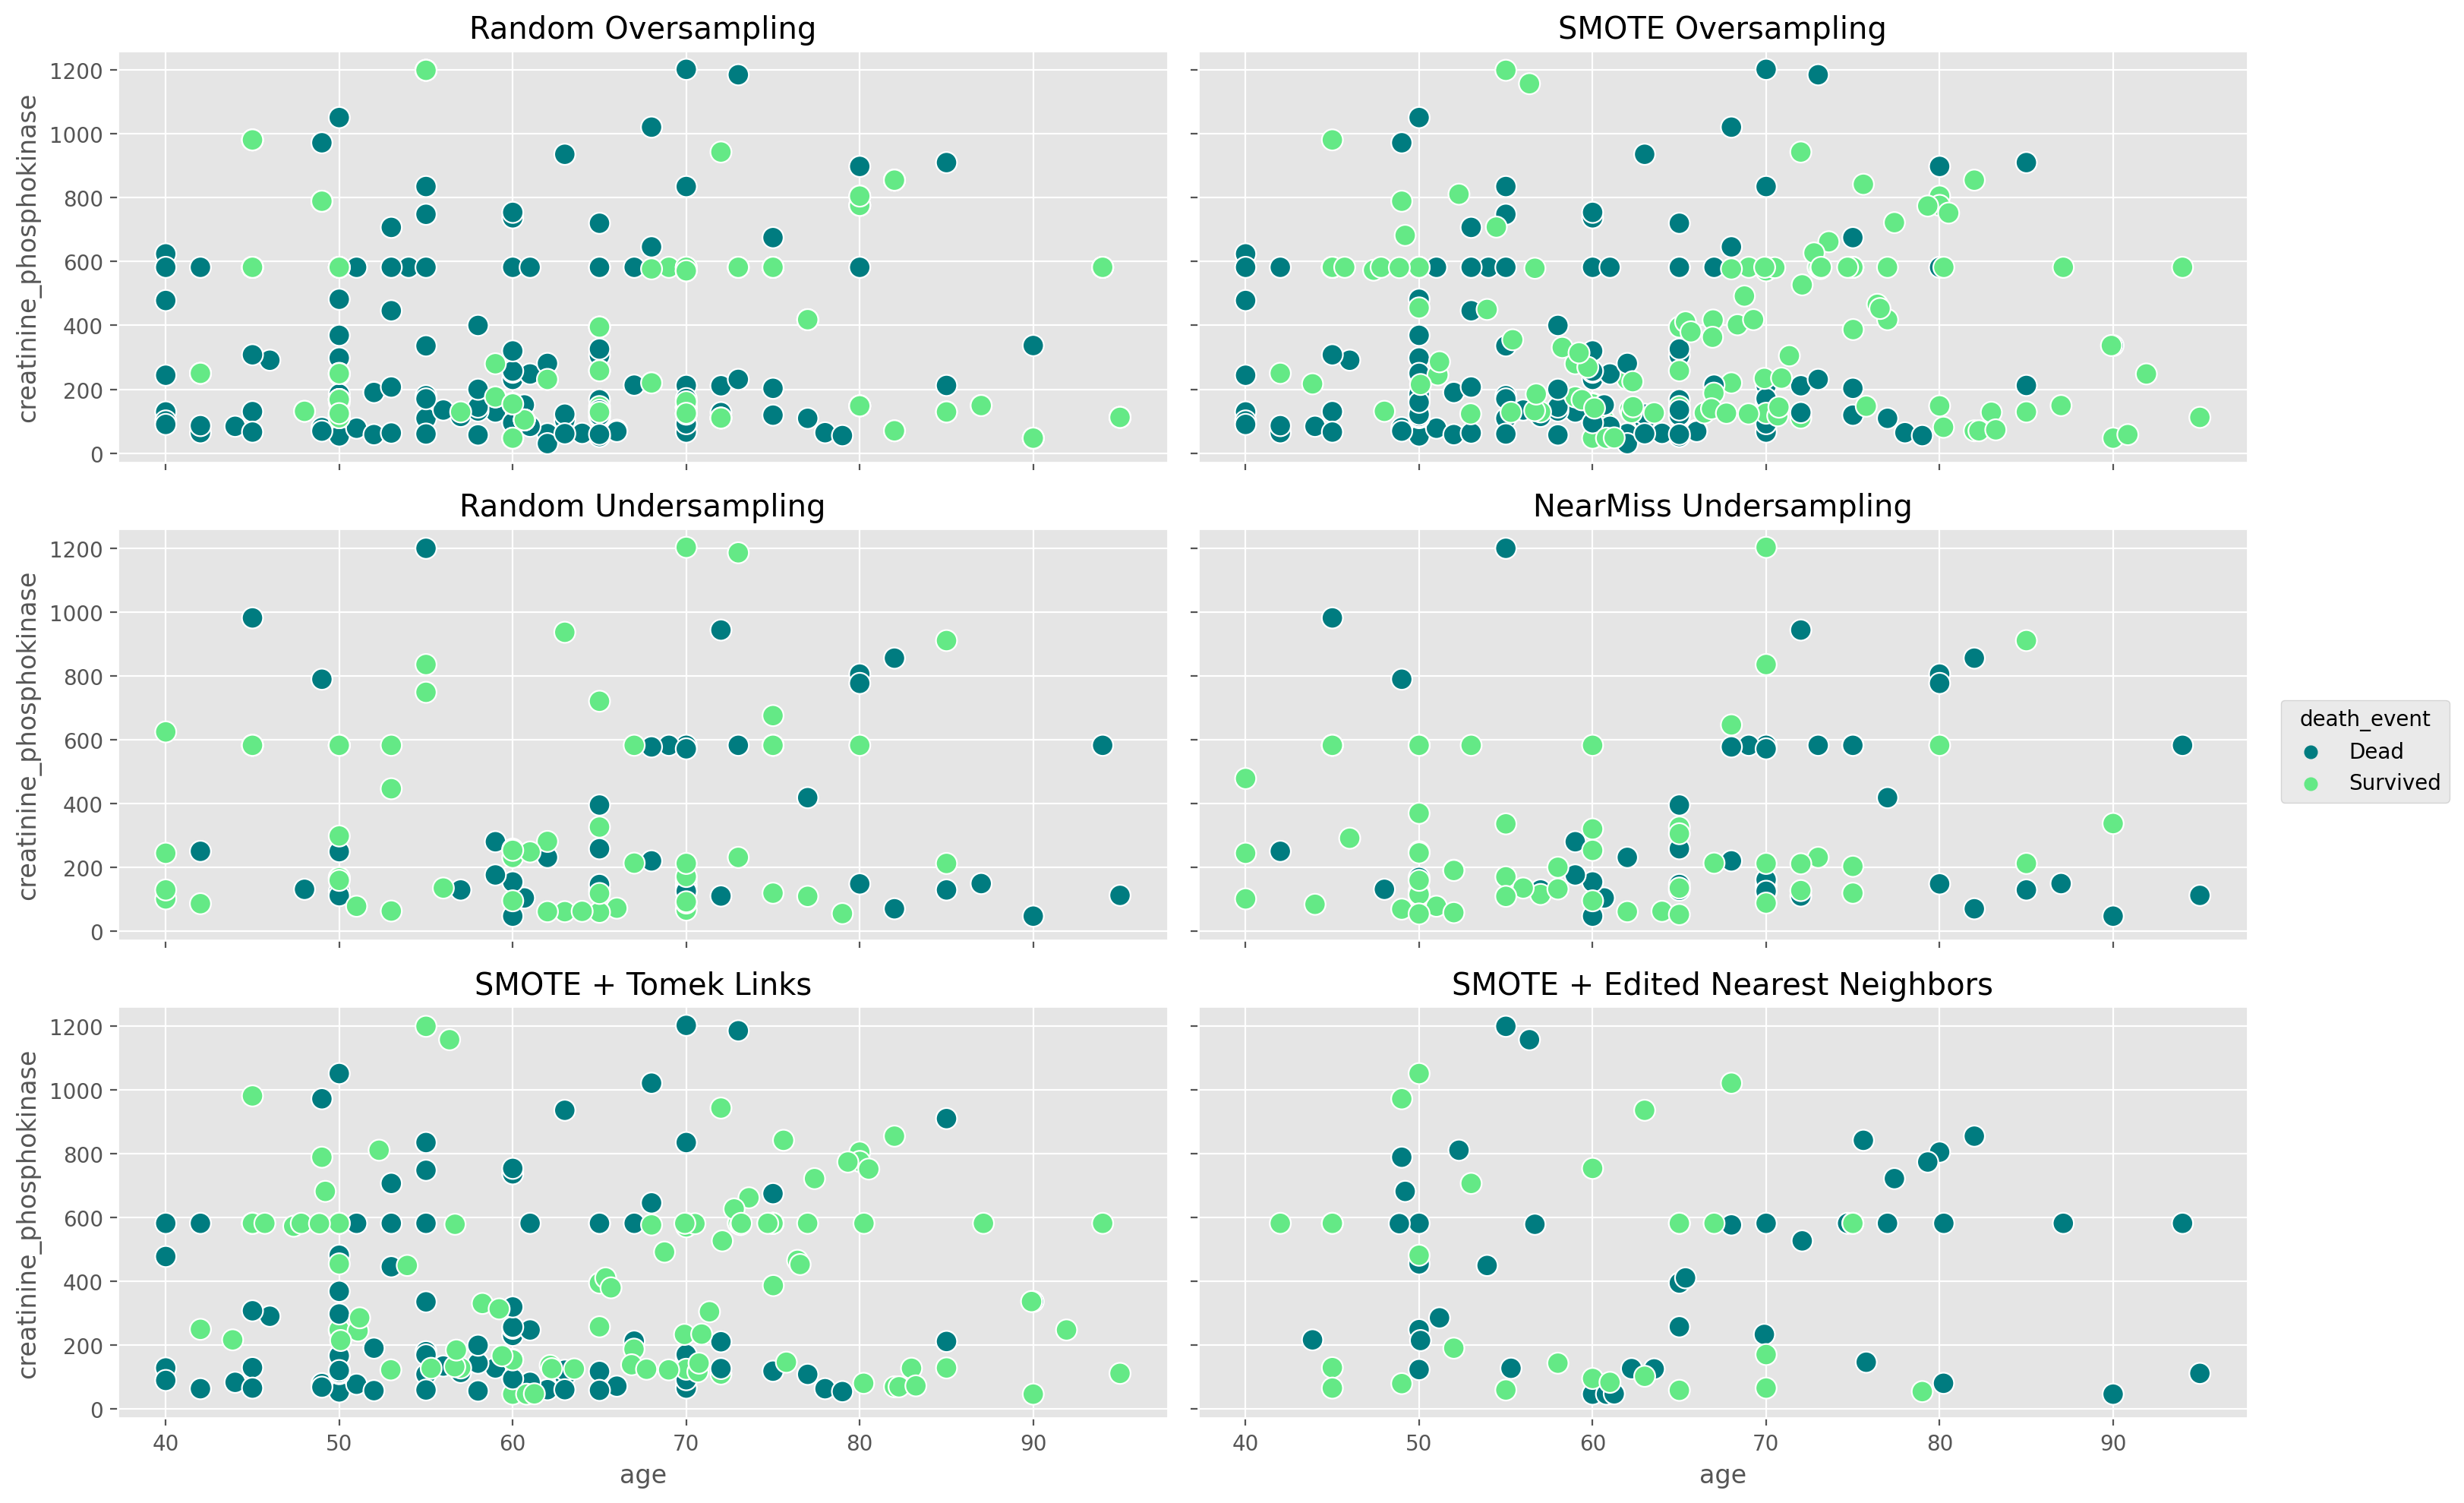

In [83]:
X_trains = [X_train_ros,X_train_smote,X_train_rus,X_train_nearmiss,X_train_smotetomek,X_train_smoteenn]
y_trains = [y_train_ros,y_train_smote,y_train_rus,y_train_nearmiss,y_train_smotetomek,y_train_smoteenn]
titles = [
    "Random Oversampling","SMOTE Oversampling","Random Undersampling",
    "NearMiss Undersampling","SMOTE + Tomek Links","SMOTE + Edited Nearest Neighbors"
]

nrows,ncols = 3,2
fig,ax = plt.subplots(nrows,ncols,figsize=(15,10),dpi=200,sharex=True,sharey=True)

n = 0
for nrow in range(nrows):
    for ncol in range(ncols):
        sns.scatterplot(
            data=pd.concat([X_trains[n],y_trains[n]],axis=1),
            x="age",
            y="creatinine_phosphokinase",
            hue="death_event",
            palette=["#007C80", "#64E986"],
            s=100,
            ax=ax[nrow,ncol]
        )
        ax[nrow,ncol].set_title(titles[n])
        ax[nrow,ncol].legend([],[],frameon=False)
        n += 1

handles,labels = ax[nrow,ncol].get_legend_handles_labels()
fig.legend(handles,labels,bbox_to_anchor=(1,0.5),loc="center left",title="death_event")

plt.tight_layout()
plt.show()

Considering the varying scales of our features, it is advisable to standardize them.

In [84]:
scaler = StandardScaler()

# Base
scaled_X_train = scaler.fit_transform(X_train)

# Random Oversampling
scaled_X_train_ros = scaler.fit_transform(X_train_ros)

# SMOTE Oversampling
scaled_X_train_smote = scaler.fit_transform(X_train_smote)

# Random Undersampling
scaled_X_train_rus = scaler.fit_transform(X_train_rus)

# NearMiss Undersampling
scaled_X_train_nearmiss = scaler.fit_transform(X_train_nearmiss)

# SMOTE + Tomek Links
scaled_X_train_smotetomek = scaler.fit_transform(X_train_smotetomek)

# SMOTE + Edited Nearest Neighbors
scaled_X_train_smoteenn = scaler.fit_transform(X_train_smoteenn)

scaled_X_test = scaler.transform(X_test)

## Model Definition and Training

To establish a baseline for model performance comparison, we initially construct models without employing any resampling methods. For this dataset, we utilize both Random Forest and Gradient Boosting models as baselines. It is important to note that there are two baseline Random Forest models, one with the class_weight parameter and one without, while there is only one baseline Gradient Boosting model as it does not incorporate the class_weight parameter. Following this, we proceed to build additional Random Forest and Gradient Boosting models using different resampling techniques.

In [85]:
# Base
rf_model_base = RandomForestClassifier(random_state=random_state)
rf_model_base.fit(scaled_X_train,y_train)

# Base (class_weight = "balanced")
rf_model_base_balanced = RandomForestClassifier(random_state=random_state,class_weight="balanced")
rf_model_base_balanced.fit(scaled_X_train,y_train)

# Random Oversampling
rf_model_ros = RandomForestClassifier(random_state=random_state)
rf_model_ros.fit(scaled_X_train_ros,y_train_ros)

# SMOTE Oversampling
rf_model_smote = RandomForestClassifier(random_state=random_state)
rf_model_smote.fit(scaled_X_train_smote,y_train_smote)

# Random Undersampling
rf_model_rus = RandomForestClassifier(random_state=random_state)
rf_model_rus.fit(scaled_X_train_rus,y_train_rus)

# NearMiss Undersampling
rf_model_nearmiss = RandomForestClassifier(random_state=random_state)
rf_model_nearmiss.fit(scaled_X_train_nearmiss,y_train_nearmiss)

# SMOTE + Tomek Links
rf_model_smotetomek = RandomForestClassifier(random_state=random_state)
rf_model_smotetomek.fit(scaled_X_train_smotetomek,y_train_smotetomek)

# SMOTE + Edited Nearest Neighbors
rf_model_smoteenn = RandomForestClassifier(random_state=random_state)
rf_model_smoteenn.fit(scaled_X_train_smoteenn,y_train_smoteenn)

RandomForestClassifier(random_state=62)

In [86]:
# Base
gb_model_base = GradientBoostingClassifier(random_state=random_state)
gb_model_base.fit(scaled_X_train,y_train)

# Random Oversampling
gb_model_ros = GradientBoostingClassifier(random_state=random_state)
gb_model_ros.fit(scaled_X_train_ros,y_train_ros)

# SMOTE Oversampling
gb_model_smote = GradientBoostingClassifier(random_state=random_state)
gb_model_smote.fit(scaled_X_train_smote,y_train_smote)

# Random Undersampling
gb_model_rus = GradientBoostingClassifier(random_state=random_state)
gb_model_rus.fit(scaled_X_train_rus,y_train_rus)

# NearMiss Undersampling
gb_model_nearmiss = GradientBoostingClassifier(random_state=random_state)
gb_model_nearmiss.fit(scaled_X_train_nearmiss,y_train_nearmiss)

# SMOTE + Tomek Links
gb_model_smotetomek = GradientBoostingClassifier(random_state=random_state)
gb_model_smotetomek.fit(scaled_X_train_smotetomek,y_train_smotetomek)

# SMOTE + Edited Nearest Neighbors
gb_model_smoteenn = GradientBoostingClassifier(random_state=random_state)
gb_model_smoteenn.fit(scaled_X_train_smoteenn,y_train_smoteenn)

GradientBoostingClassifier(random_state=62)

## Prediction Model

In [87]:
# Base
rf_pred_base = rf_model_base.predict(scaled_X_test)
rf_proba_base = rf_model_base.predict_proba(scaled_X_test)

# Base (class_weight = "balanced")
rf_pred_base_balanced = rf_model_base_balanced.predict(scaled_X_test)
rf_proba_base_balanced = rf_model_base_balanced.predict_proba(scaled_X_test)

# Random Oversampling
rf_pred_ros = rf_model_ros.predict(scaled_X_test)
rf_proba_ros = rf_model_ros.predict_proba(scaled_X_test)

# SMOTE Oversampling
rf_pred_smote = rf_model_smote.predict(scaled_X_test)
rf_proba_smote = rf_model_smote.predict_proba(scaled_X_test)

# Random Undersampling
rf_pred_rus = rf_model_rus.predict(scaled_X_test)
rf_proba_rus = rf_model_rus.predict_proba(scaled_X_test)

# NearMiss Undersampling
rf_pred_nearmiss = rf_model_nearmiss.predict(scaled_X_test)
rf_proba_nearmiss = rf_model_nearmiss.predict_proba(scaled_X_test)

# SMOTE + Tomek Links
rf_pred_smotetomek = rf_model_smotetomek.predict(scaled_X_test)
rf_proba_smotetomek = rf_model_smotetomek.predict_proba(scaled_X_test)

# SMOTE + Edited Nearest Neighbors
rf_pred_smoteenn = rf_model_smoteenn.predict(scaled_X_test)
rf_proba_smoteenn = rf_model_smoteenn.predict_proba(scaled_X_test)

In [88]:
# Base
gb_pred_base = gb_model_base.predict(scaled_X_test)
gb_proba_base = gb_model_base.predict_proba(scaled_X_test)

# Random Oversampling
gb_pred_ros = gb_model_ros.predict(scaled_X_test)
gb_proba_ros = gb_model_ros.predict_proba(scaled_X_test)

# SMOTE Oversampling
gb_pred_smote = gb_model_smote.predict(scaled_X_test)
gb_proba_smote = gb_model_smote.predict_proba(scaled_X_test)

# Random Undersampling
gb_pred_rus = gb_model_rus.predict(scaled_X_test)
gb_proba_rus = gb_model_rus.predict_proba(scaled_X_test)

# NearMiss Undersampling
gb_pred_nearmiss = gb_model_nearmiss.predict(scaled_X_test)
gb_proba_nearmiss = gb_model_nearmiss.predict_proba(scaled_X_test)

# SMOTE + Tomek Links
gb_pred_smotetomek = gb_model_smotetomek.predict(scaled_X_test)
gb_proba_smotetomek = gb_model_smotetomek.predict_proba(scaled_X_test)

# SMOTE + Edited Nearest Neighbors
gb_pred_smoteenn = gb_model_smoteenn.predict(scaled_X_test)
gb_proba_smoteenn = gb_model_smoteenn.predict_proba(scaled_X_test)

## Model Evaluation

To initiate the evaluation process, let's conduct a preliminary assessment by generating a confusion matrix plot for each model.

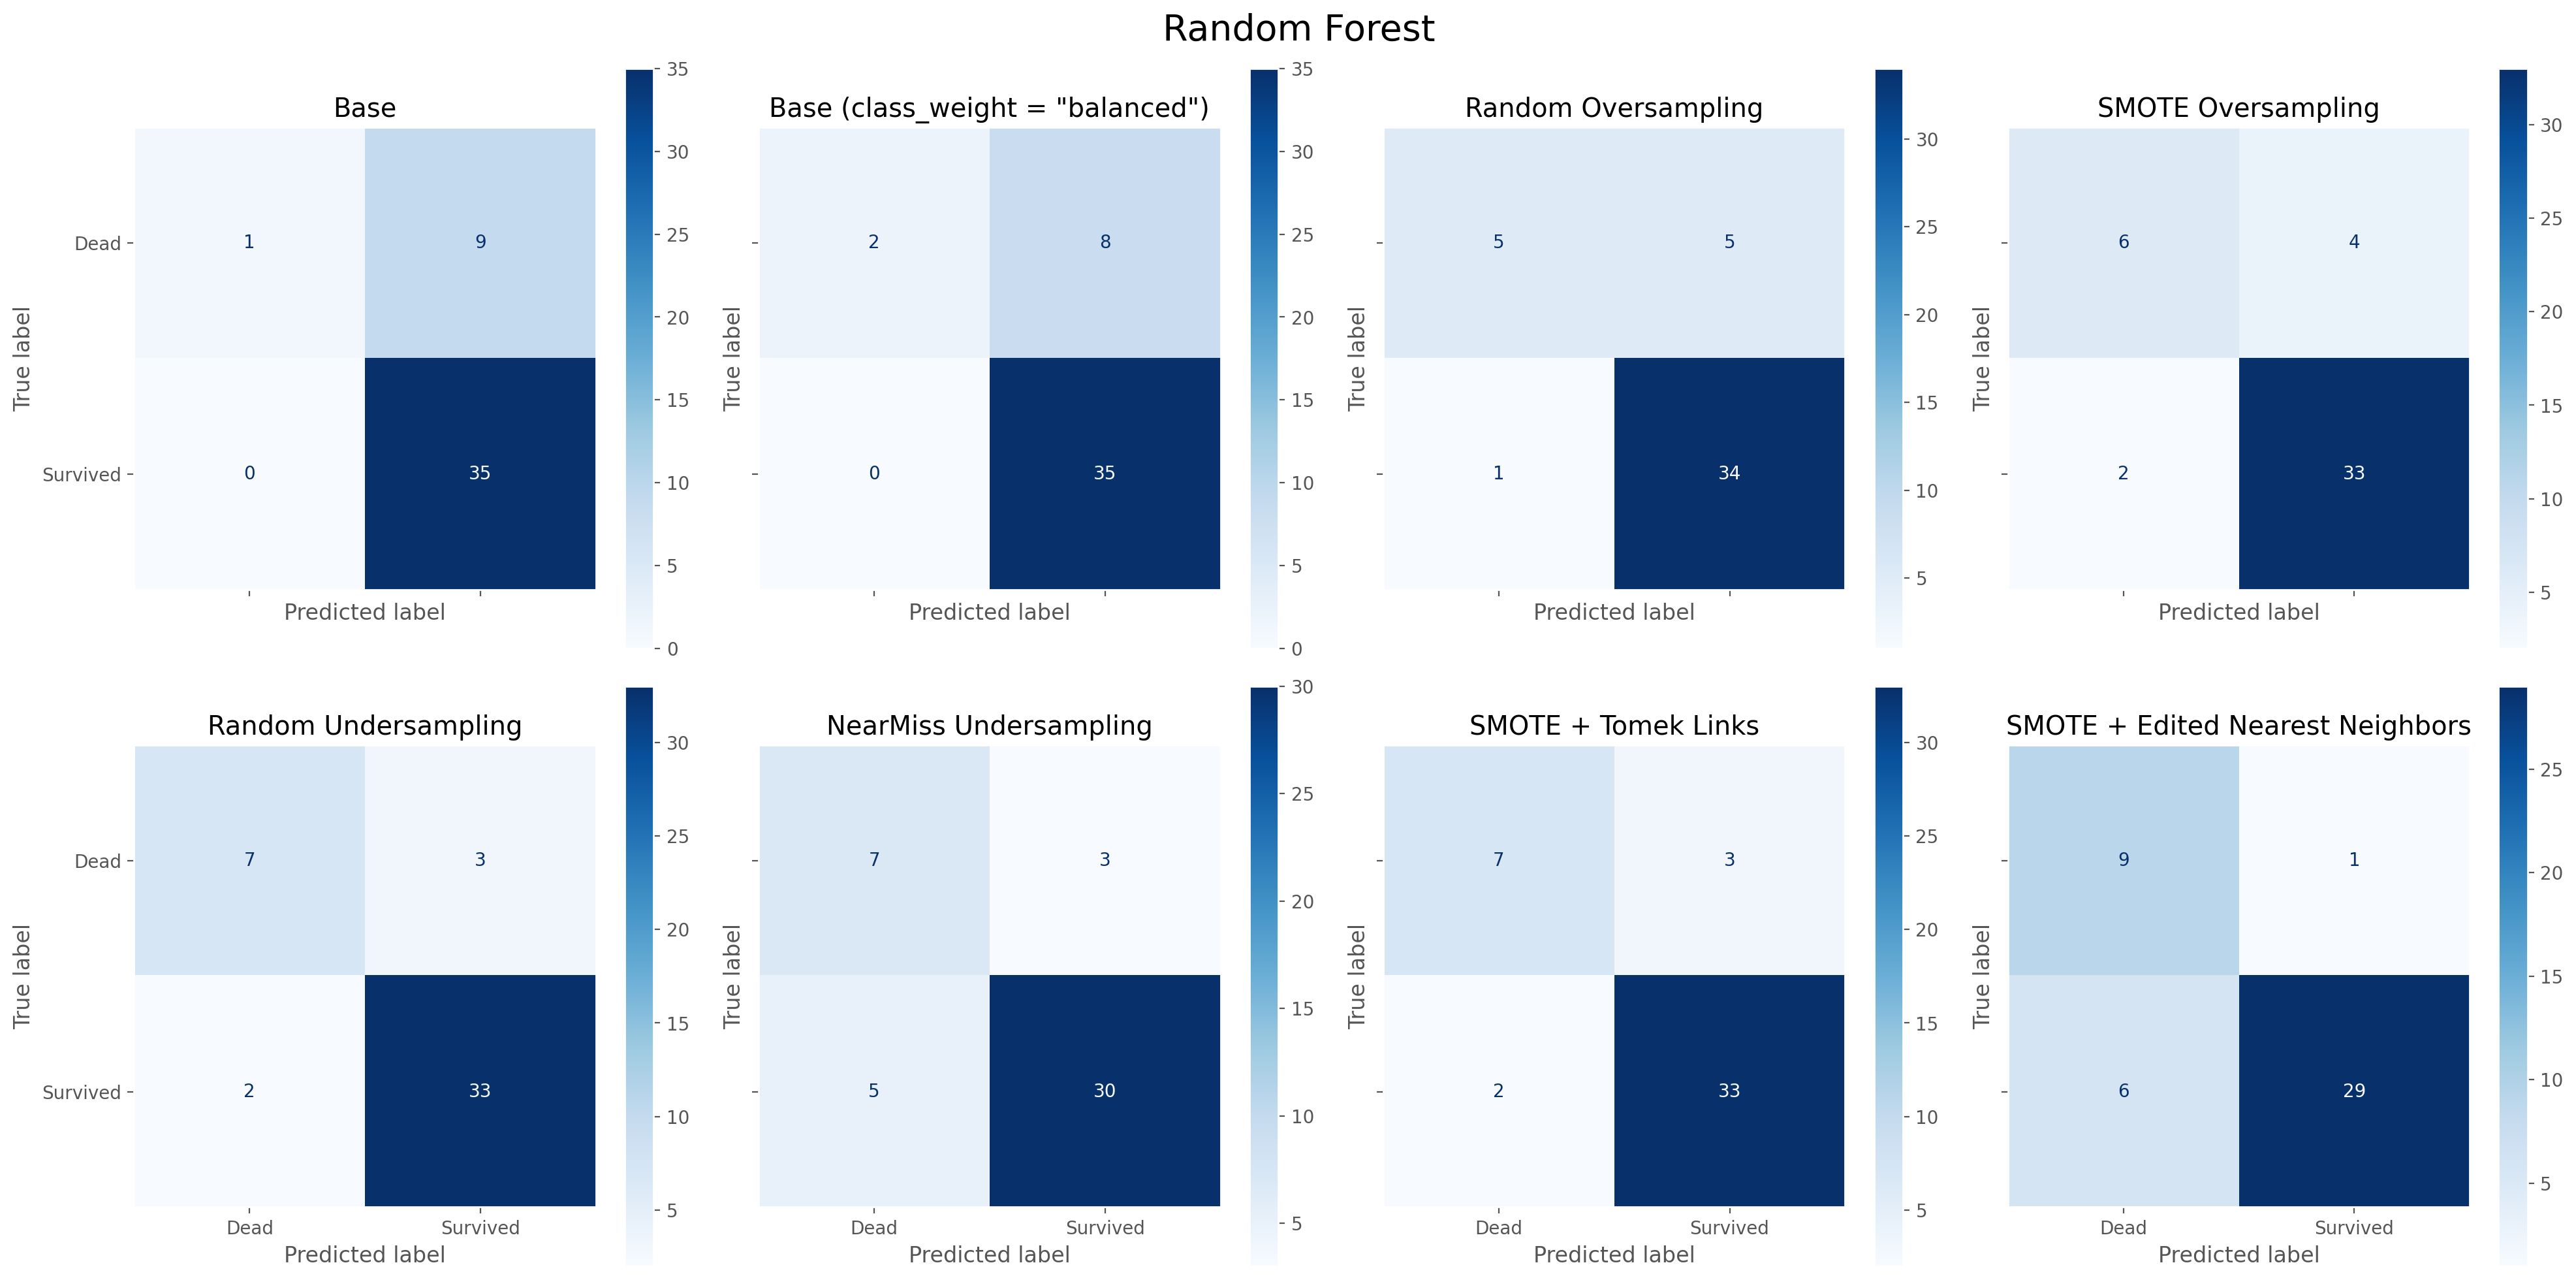

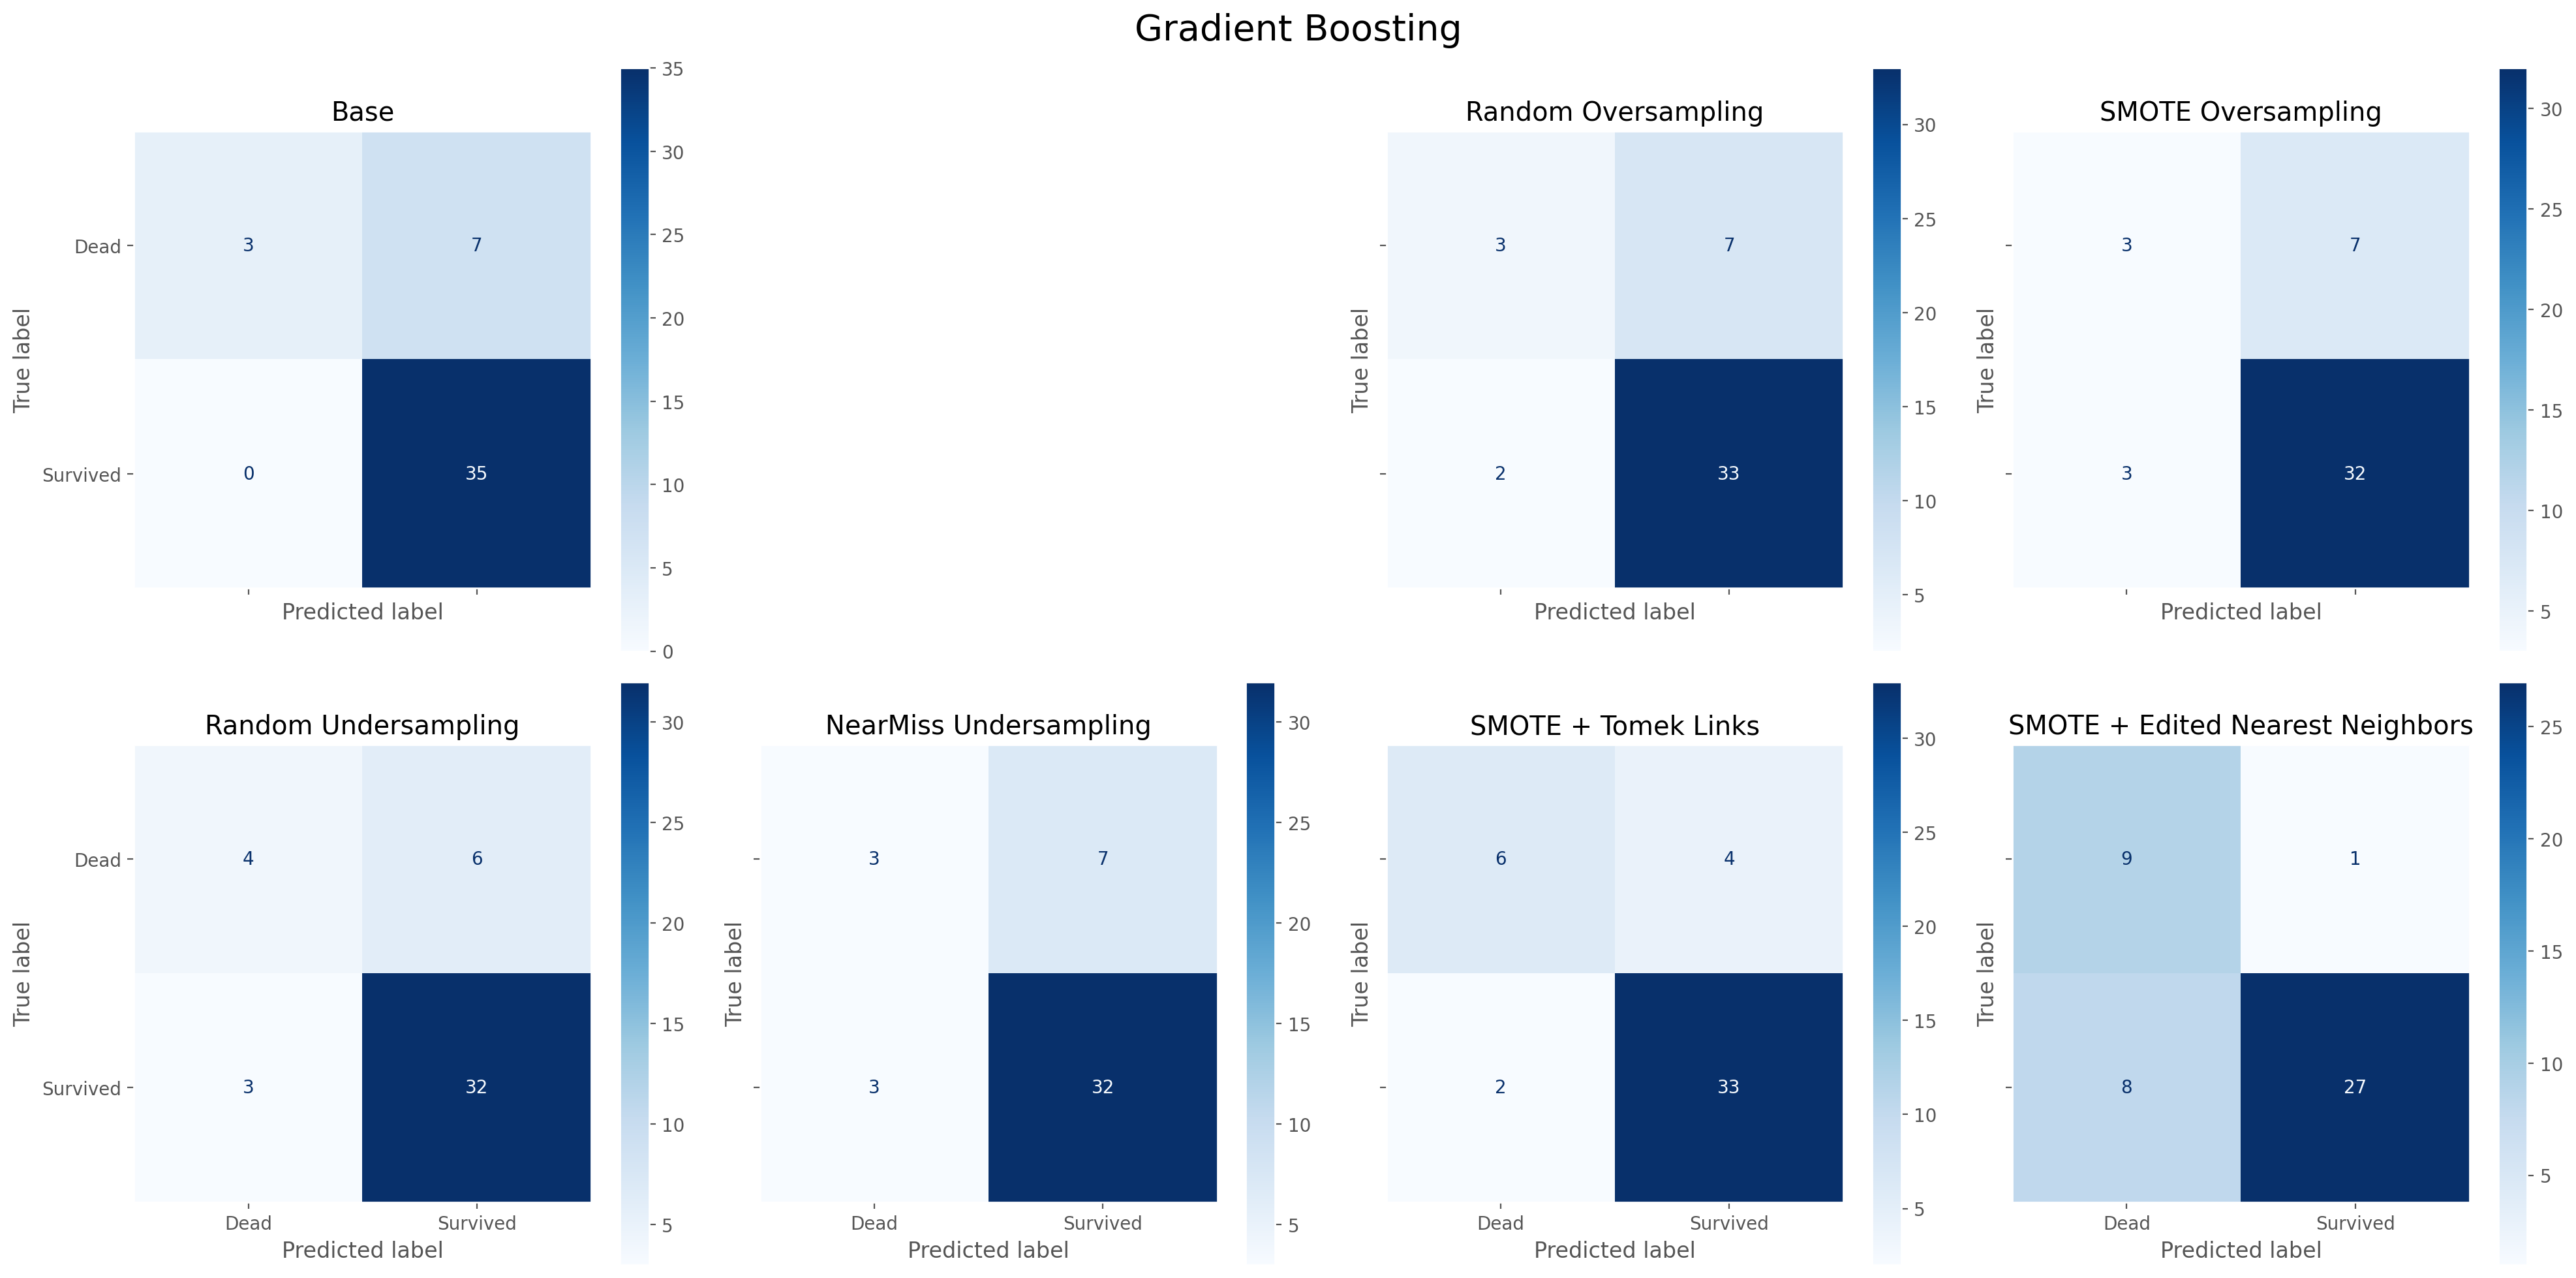

In [89]:
rf_preds = [rf_pred_base,rf_pred_base_balanced,rf_pred_ros,rf_pred_smote,rf_pred_rus,rf_pred_nearmiss,rf_pred_smotetomek,rf_pred_smoteenn]
rf_titles = [
    "Base",'Base (class_weight = "balanced")',"Random Oversampling","SMOTE Oversampling",
    "Random Undersampling","NearMiss Undersampling","SMOTE + Tomek Links","SMOTE + Edited Nearest Neighbors"
]

gb_preds = [gb_pred_base,[""],gb_pred_ros,gb_pred_smote,gb_pred_rus,gb_pred_nearmiss,gb_pred_smotetomek,gb_pred_smoteenn]
gb_titles = [
    "Base","","Random Oversampling","SMOTE Oversampling",
    "Random Undersampling","NearMiss Undersampling","SMOTE + Tomek Links","SMOTE + Edited Nearest Neighbors"
]

for pred,title,suptitle in zip([rf_preds,gb_preds],[rf_titles,gb_titles],["Random Forest","Gradient Boosting"]):
    nrows,ncols = 2,4
    fig,ax = plt.subplots(nrows,ncols,figsize=(20,10),dpi=200,sharex=True,sharey=True)

    n = 0
    for nrow in range(nrows):
        for ncol in range(ncols):
            if len(pred[n]) == 1:
                pass
                n += 1
            else:
                ConfusionMatrixDisplay.from_predictions(y_test,pred[n],cmap="Blues",ax=ax[nrow,ncol])
                ax[nrow,ncol].set_title(title[n])
                ax[nrow,ncol].grid(False)
                n += 1

                if n == len(pred):
                    break

    for ax in ax.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)

    plt.suptitle(suptitle,fontsize=20)
    plt.tight_layout()
    plt.show()

For a more comprehensive evaluation, let's analyze the percentages of correct and incorrect predictions made by each model. It is important to note that accuracy may not be the most appropriate metric for evaluating models, particularly in the case of an imbalanced dataset. Instead, metrics such as precision, recall, and F1-score should be considered. In this analysis, we will focus on recall, which measures the ratio of correctly classified positive samples to the total number of positive samples (as indicated by the green bars on the graph). From the results, it is evident that among all the resampling methods applied, the SMOTE + ENN method demonstrates the best performance for both the Random Forest and Gradient Boosting models.

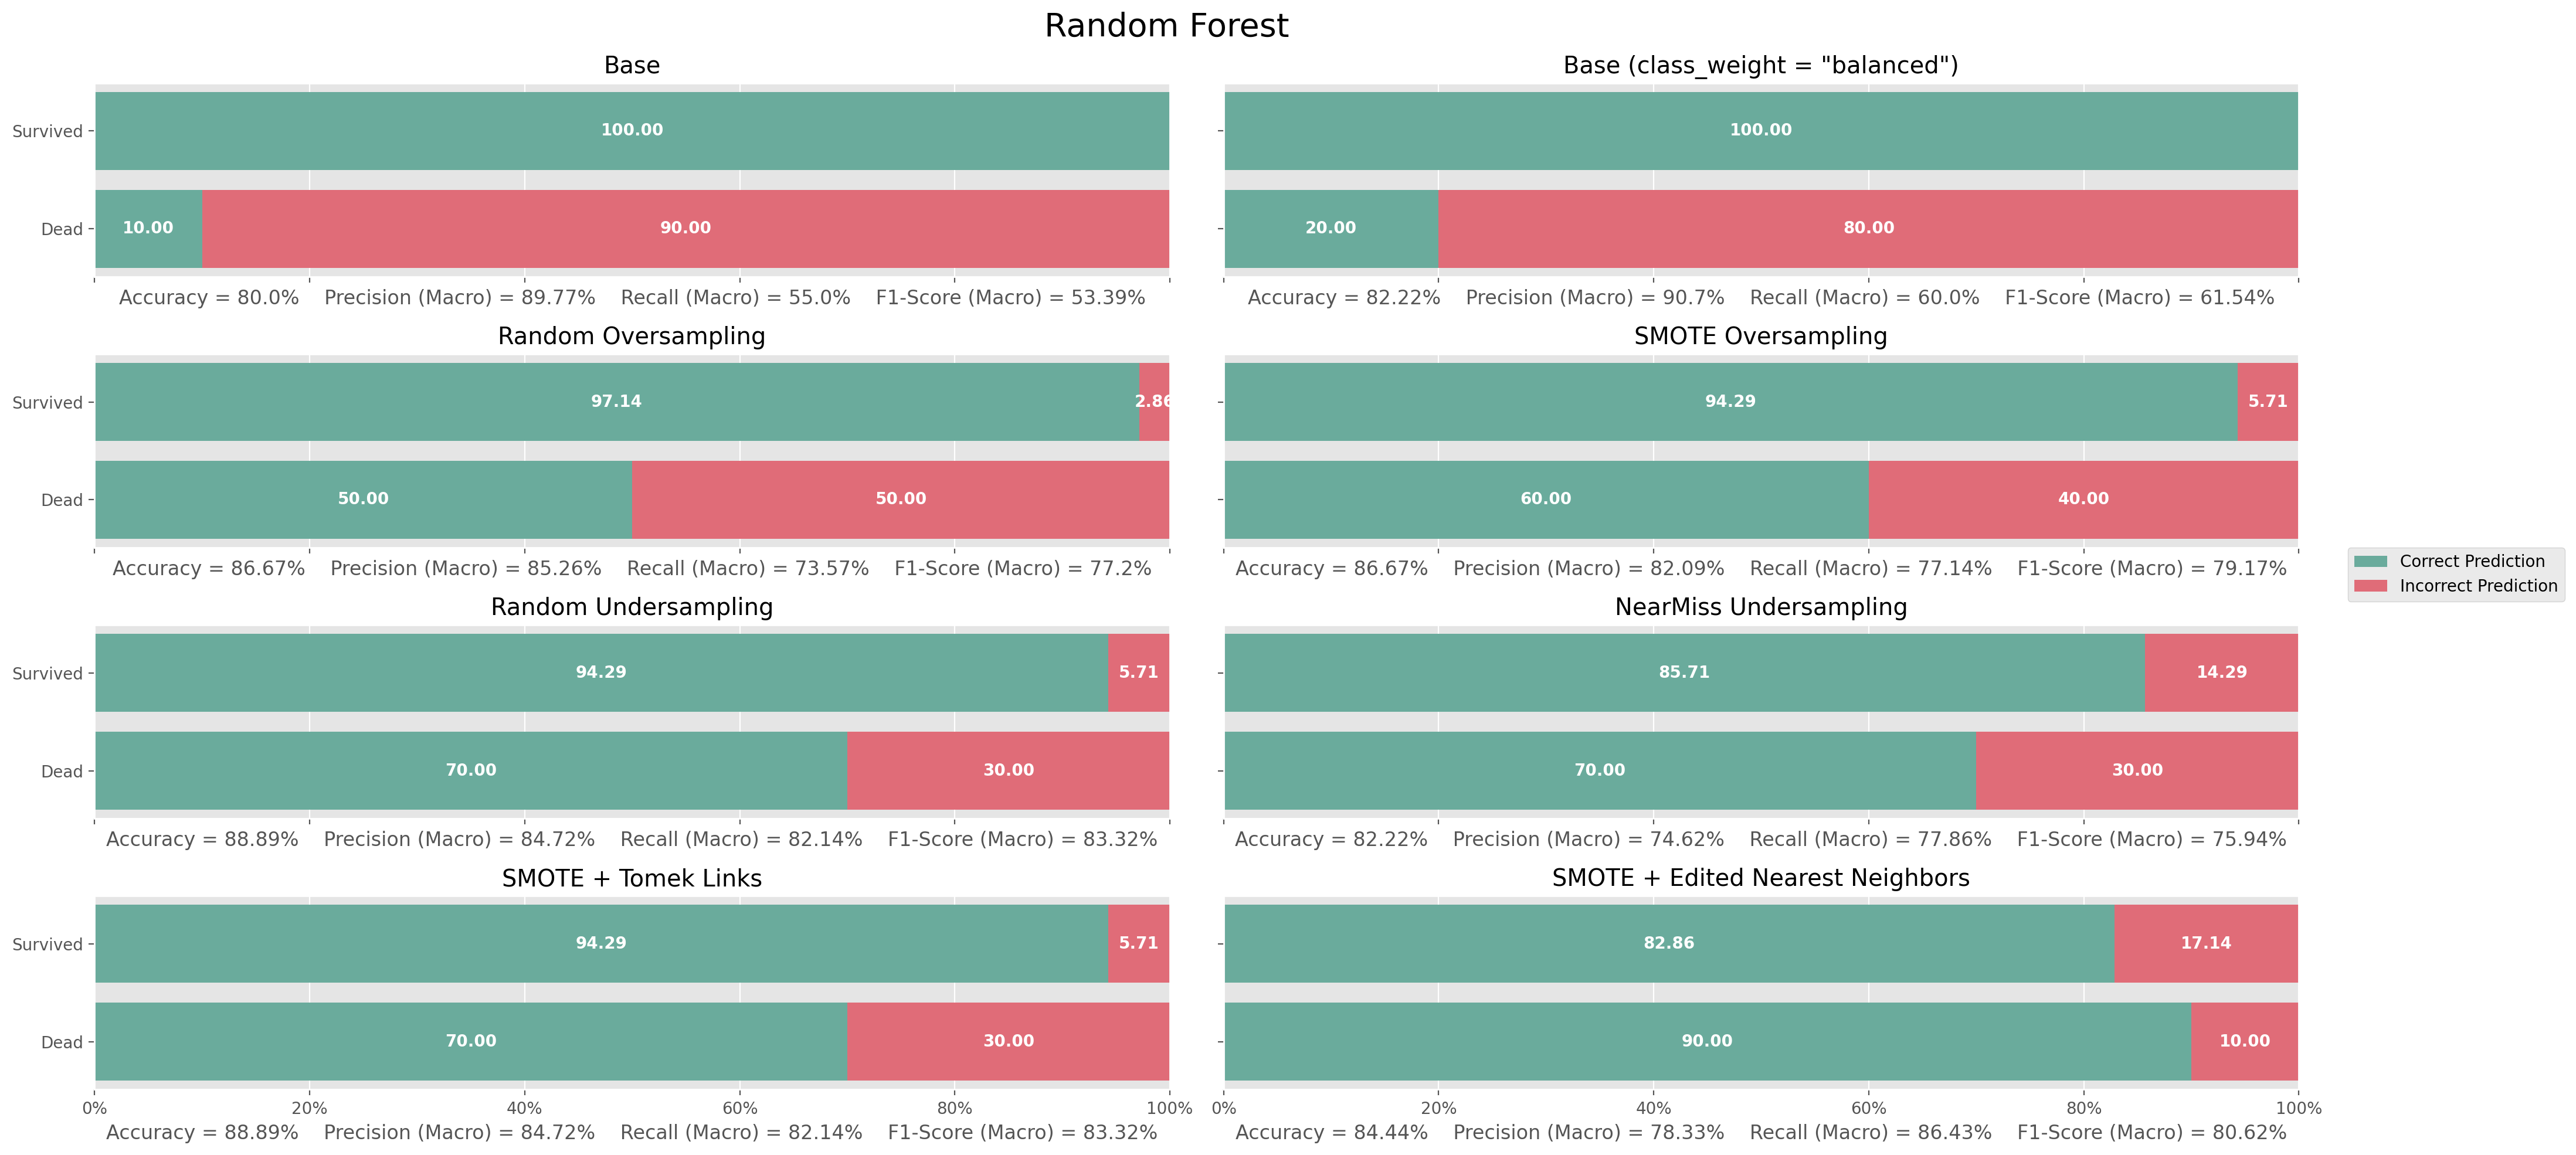

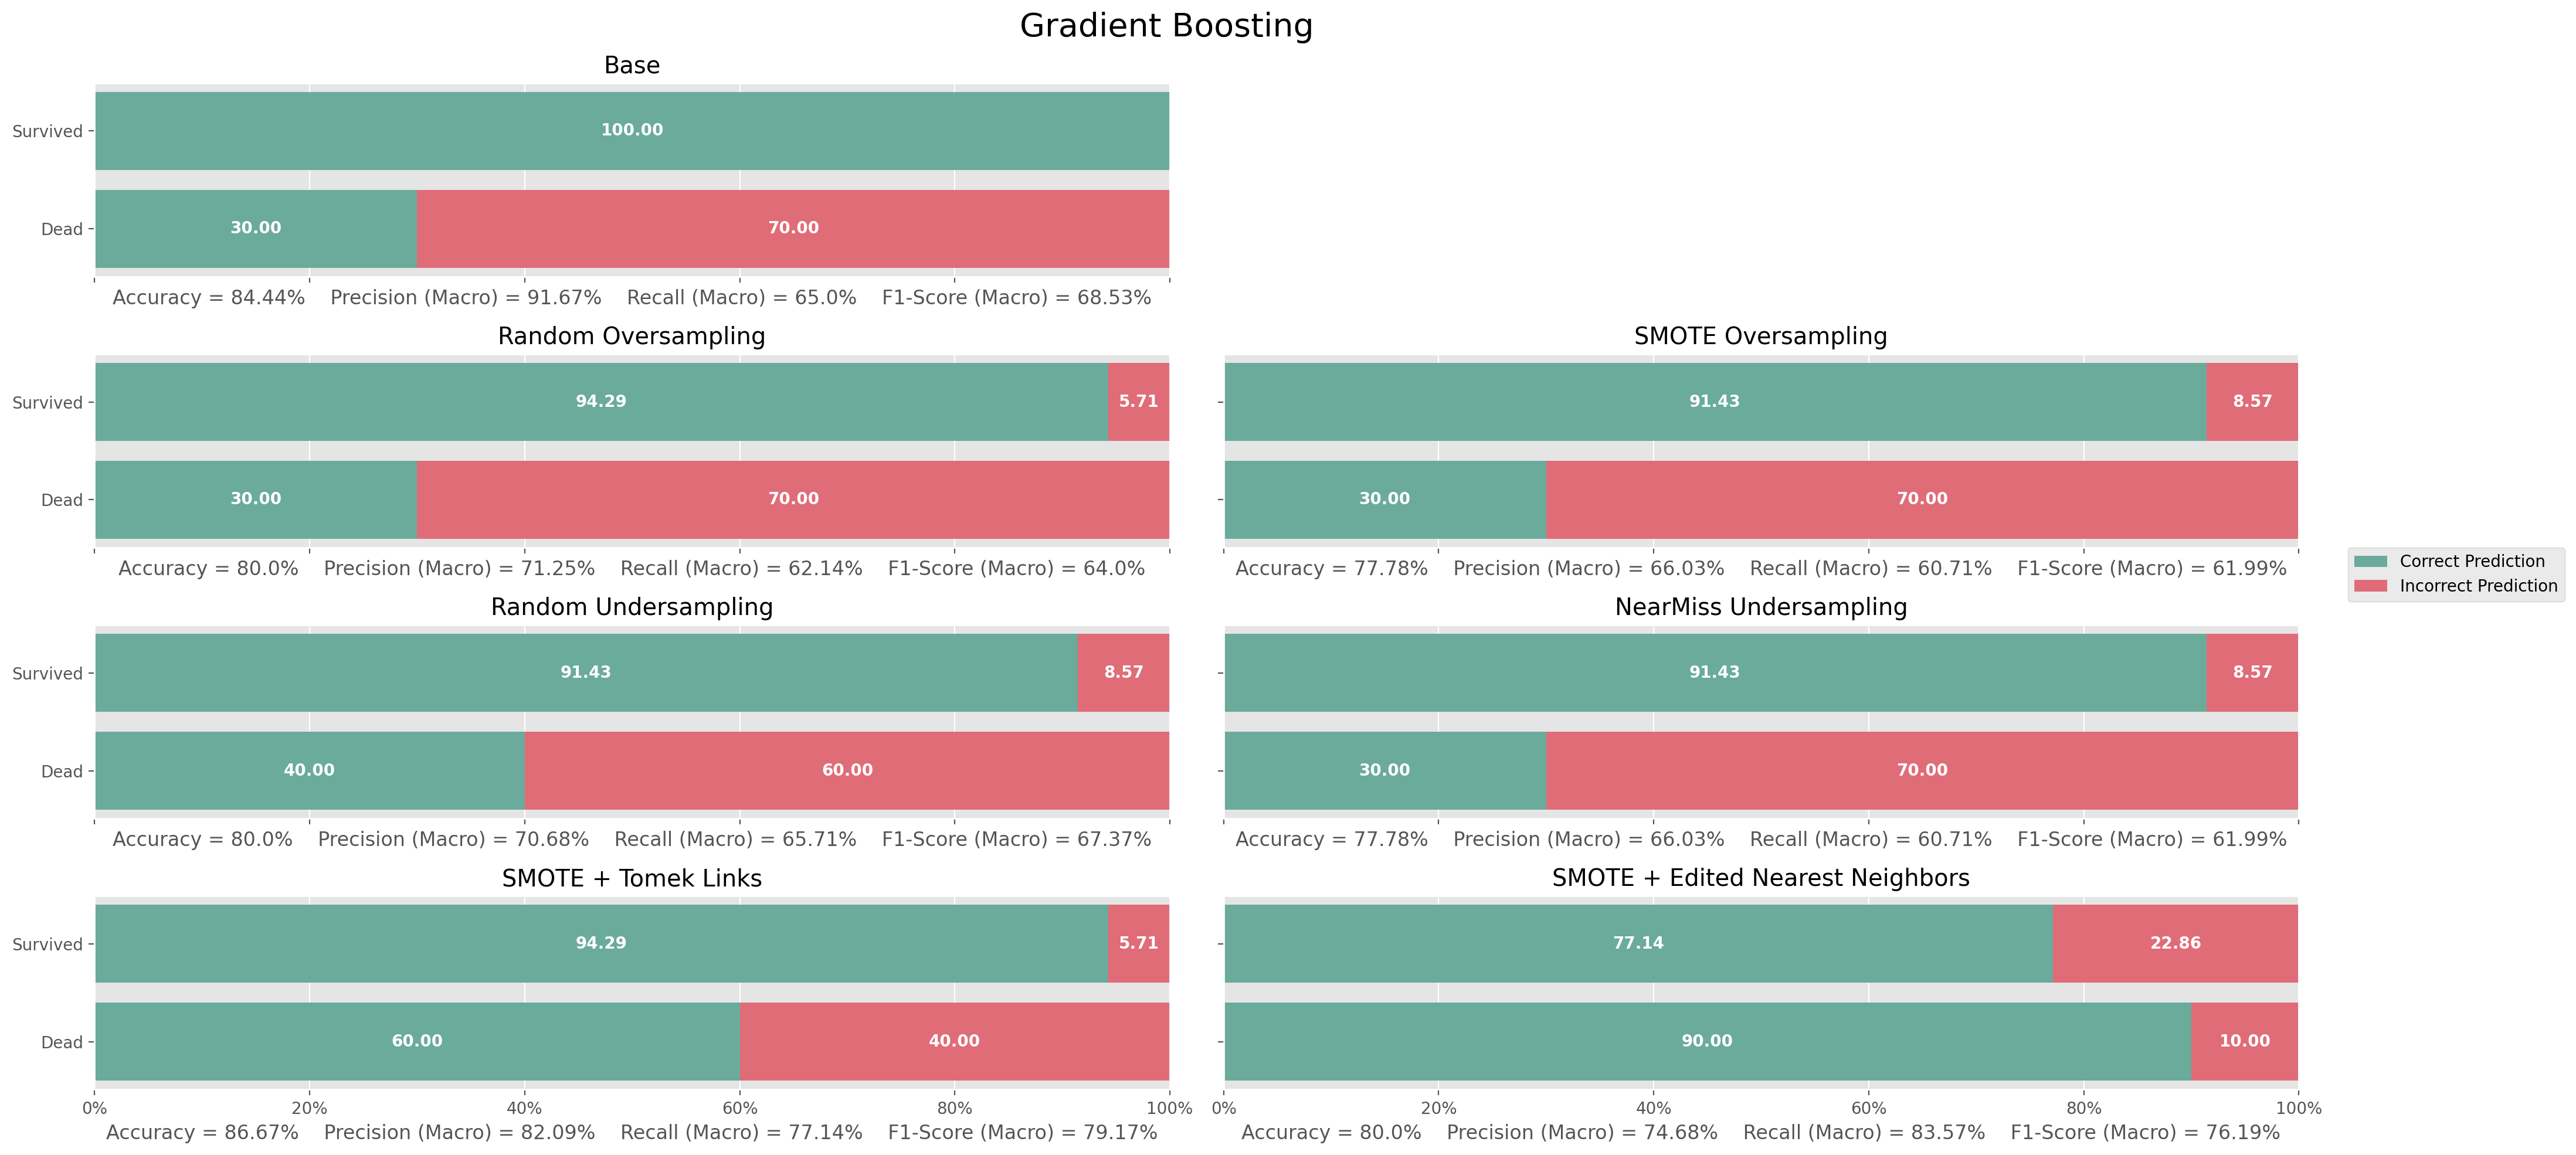

In [90]:
for pred,title,suptitle in zip([rf_preds,gb_preds],[rf_titles,gb_titles],["Random Forest","Gradient Boosting"]):
    nrows,ncols = 4,2
    fig,ax = plt.subplots(nrows,ncols,figsize=(20,10),dpi=200,sharex=True,sharey=True)

    n = 0
    for nrow in range(nrows):
        for ncol in range(ncols):
            if len(pred[n]) == 1:
                pass
                n += 1
            else:
                true_survived = recall_score(y_test,pred[n],pos_label="Survived") * 100
                false_survived = 100 - true_survived
                true_dead = recall_score(y_test,pred[n],pos_label="Dead") * 100
                false_dead = 100 - true_dead
                
                accuracy = accuracy_score(y_test,pred[n])
                precision = precision_score(y_test,pred[n],average="macro")
                recall = recall_score(y_test,pred[n],average="macro")
                f1 = f1_score(y_test,pred[n],average="macro")

                if true_dead == 100:
                    ax[nrow,ncol].barh("Dead",true_dead,color="#6AAB9C",label="Correct Prediction")
                    ax[nrow,ncol].barh("Survived",true_survived,color="#6AAB9C")
                    ax[nrow,ncol].barh("Survived",false_survived,left=true_survived,color="#E06C78")
                elif false_dead == 100:
                    ax[nrow,ncol].barh("Dead",false_dead,color="#E06C78",label="Incorrect Prediction")
                    ax[nrow,ncol].barh("Survived",true_survived,color="#6AAB9C")
                    ax[nrow,ncol].barh("Survived",false_survived,left=true_survived,color="#E06C78")
                elif true_survived == 100:
                    ax[nrow,ncol].barh("Dead",true_dead,color="#6AAB9C",label="Correct Prediction")
                    ax[nrow,ncol].barh("Dead",false_dead,left=true_dead,color="#E06C78",label="Incorrect Prediction")
                    ax[nrow,ncol].barh("Survived",true_survived,color="#6AAB9C")
                elif false_survived / (true_survived + false_survived) * 10 == 100:
                    ax[nrow,ncol].barh("Dead",true_dead,color="#6AAB9C",label="Correct Prediction")
                    ax[nrow,ncol].barh("Dead",false_dead,left=true_dead,color="#E06C78",label="Incorrect Prediction")
                    ax[nrow,ncol].barh("Survived",false_survived,color="#E06C78")
                else:
                    ax[nrow,ncol].barh("Dead",true_dead,color="#6AAB9C",label="Correct Prediction")
                    ax[nrow,ncol].barh("Dead",false_dead,left=true_dead,color="#E06C78",label="Incorrect Prediction")
                    ax[nrow,ncol].barh("Survived",true_survived,color="#6AAB9C")
                    ax[nrow,ncol].barh("Survived",false_survived,left=true_survived,color="#E06C78")

                ax[nrow,ncol].set_title(title[n])
                ax[nrow,ncol].set_xlim(xmax=100)
                ax[nrow,ncol].set_xlabel(
                    f"Accuracy = {round(accuracy * 100,2)}%    Precision (Macro) = {round(precision * 100,2)}%    Recall (Macro) = {round(recall * 100,2)}%    F1-Score (Macro) = {round(f1 * 100,2)}%"
                )

                for container in ax[nrow,ncol].containers:
                    ax[nrow,ncol].bar_label(container,fmt="%.2f",label_type="center",color="white",fontweight="bold")

                n += 1

    ax[nrow,ncol].set_xticks(np.arange(0,101,20),[f"{xtick}%" for xtick in np.arange(0,101,20)])
    handles,labels = ax[nrow,ncol].get_legend_handles_labels()
    fig.legend(handles,labels,bbox_to_anchor=(1,0.5),loc="center left")

    for ax in ax.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)

    plt.suptitle(suptitle,fontsize=20)
    plt.tight_layout()
    plt.show()

Let's examine the prediction results of the Random Forest and Gradient Boosting models that utilize the SMOTE + ENN method.

In [91]:
pd.DataFrame({
    "probability_survived":rf_proba_smoteenn[:,1] * 100,
    "probability_dead":rf_proba_smoteenn[:,0] * 100,
    "prediction":rf_pred_smoteenn,
    "actual":y_test,
    "conclusion":[True if i == j else False for i,j in zip(y_test,rf_pred_smoteenn)]
}).reset_index(drop=True).head(10)

probability_survived  probability_dead prediction    actual  conclusion
0                  66.0              34.0   Survived  Survived        True
1                  87.0              13.0   Survived  Survived        True
2                  61.0              39.0   Survived  Survived        True
3                  30.0              70.0       Dead      Dead        True
4                  43.0              57.0       Dead      Dead        True
5                  82.0              18.0   Survived  Survived        True
6                  85.0              15.0   Survived  Survived        True
7                  41.0              59.0       Dead  Survived       False
8                   8.0              92.0       Dead      Dead        True
9                  29.0              71.0       Dead  Survived       False

In [92]:
pd.DataFrame({
    "probability_survived":gb_proba_smoteenn[:,1] * 100,
    "probability_dead":gb_proba_smoteenn[:,0] * 100,
    "prediction":gb_pred_smoteenn,
    "actual":y_test,
    "conclusion":[True if i == j else False for i,j in zip(y_test,gb_pred_smoteenn)]
}).reset_index(drop=True).head(10)

probability_survived  probability_dead prediction    actual  conclusion
0              6.174211         93.825789       Dead  Survived       False
1             99.982158          0.017842   Survived  Survived        True
2             96.998544          3.001456   Survived  Survived        True
3              2.138004         97.861996       Dead      Dead        True
4              5.669722         94.330278       Dead      Dead        True
5             99.982812          0.017188   Survived  Survived        True
6             99.588665          0.411335   Survived  Survived        True
7             69.955968         30.044032   Survived  Survived        True
8              0.011208         99.988792       Dead      Dead        True
9              0.365885         99.634115       Dead  Survived       False

## Final Model

Considering that the SMOTE + ENN method has been identified as the most effective resampling technique for this dataset, we will apply it to resample the entire dataset.

In [93]:
smoteenn = SMOTEENN(random_state=random_state)
X_smoteenn,y_smoteenn = smoteenn.fit_resample(X,y)

Let's create the final models by training them with the resampled whole dataset.

In [94]:
# Random Forest
final_rf_model = RandomForestClassifier(random_state=random_state)
final_rf_model.fit(X_smoteenn,y_smoteenn)

# Gradient Boosting
final_gb_model = GradientBoostingClassifier(random_state=random_state)
final_gb_model.fit(X_smoteenn,y_smoteenn)

GradientBoostingClassifier(random_state=62)

Let's save the final models for future use.

In [95]:
models = [final_rf_model,final_gb_model]
names = ["random_forest_smote_enn_model_fp3","gradient_boosting_smote_enn_model_fp3"]
extension = "json"

for model,name in zip(models,names):
    with open(f"{name}.{extension}","wb") as files:
        dump(model,files)
    print(f"{name}.{extension} has been downloaded")

random_forest_smote_enn_model_fp3.json has been downloaded
gradient_boosting_smote_enn_model_fp3.json has been downloaded


## Conclusion For Final Project 3:

the SMOTE + ENN method proves to be highly effective in balancing the dataset and enhancing the performance of our models. The Random Forest model demonstrates 82.86% and 90% accuracy in predicting the Survival and Dead classes, respectively, while the Gradient Boosting model achieves 77.14% and 90% accuracy. Considering the slightly superior performance of the Random Forest model, it is recommended for utilization. This project highlights the efficacy of ensemble methods in machine learning for binary classification tasks, specifically in analyzing electronic health records of patients with cardiovascular heart diseases.